In [1]:
import time
t_start = time.time()

import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"  # suppress tensorflow information messages

import sys
import numpy as np
from scipy import stats
import scipy as sp
import multiprocessing
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm, Normalize
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

HOME_PATH = os.path.abspath("/root/work/QE-mls") # path to QE_mls
sys.path.append(HOME_PATH + "/qe")
print("Home path:", HOME_PATH)

# custom modules
import paper_plot as pp
import full_data as data

Home path: /root/work/QE-mls
['/CGLMP', '/RecoLep0', '/RecoLep1', '/RecoMET', '/TruthHiggs', '/TruthLep0', '/TruthLep1', '/TruthMET', '/TruthNu0', '/TruthNu1', '/TruthW0', '/TruthW1']


In [2]:
# ROOT need to be imported after tensorflow
import ROOT
from ROOT.Math import PxPyPzEVector, Boost
from ROOT import TVector3

# some global variables
plot = pp.Plotter()
WORKERS = 16

In [3]:
import h5py


def load_particles_from_h5(filename):
    """
    Load particle data from an HDF5 file

    Args:
        filename: Path to the HDF5 file

    Returns:
        Dictionary with the loaded data
    """
    result = {}

    with h5py.File(filename, "r") as f:
        # For each group in the file
        for group_name in f.keys():
            group_data = {}

            # Load datasets (numpy arrays)
            for dataset_name in f[group_name].keys():
                group_data[dataset_name] = f[group_name][dataset_name][:]

            # Load attributes (scalars)
            for attr_name, attr_value in f[group_name].attrs.items():
                group_data[attr_name] = attr_value

            result[group_name] = group_data

    return result

In [4]:
def pt(px, py):
    return np.sqrt(np.square(px) + np.square(py))


def eta(px, py, pz):
    pt = np.sqrt(np.square(px) + np.square(py))
    return np.arcsinh(np.divide(pz, pt))


def phi(px, py):
    return np.arctan2(py, px)


def deta(eta1, eta2):
    return np.abs(eta1 - eta2)


def dphi_pi(phi1, phi2):
    phi_diff = phi1 - phi2
    phi_diff = np.where(phi_diff < 0.0, -phi_diff, phi_diff)
    phi_diff = np.where(phi_diff > 2.0 * np.pi, phi_diff - 2.0 * np.pi, phi_diff)
    phi_diff = np.where(phi_diff >= np.pi, 2.0 * np.pi - phi_diff, phi_diff)
    return np.divide(phi_diff, np.pi)

In [5]:
mc20_data = load_particles_from_h5("/root/data/mc20_truth.h5")
# mc20_data.keys()
mc20_data_LL = load_particles_from_h5("/root/data/mc20_truth_LL.h5")

In [6]:
# SM truth
truth_lead_lep = mc20_data["truth_lead_lep"]
truth_sublead_lep = mc20_data["truth_sublead_lep"]
truth_lead_nu = mc20_data["truth_lead_nu"]
truth_sublead_nu = mc20_data["truth_sublead_nu"]
truth_lead_lep_p4 = mc20_data["truth_lead_lep"]["p4"]
truth_sublead_lep_p4 = mc20_data["truth_sublead_lep"]["p4"]
truth_lead_nu_p4 = mc20_data["truth_lead_nu"]["p4"]
truth_sublead_nu_p4 = mc20_data["truth_sublead_nu"]["p4"]
truth_met_pt = np.sqrt(np.square((truth_lead_nu_p4 + truth_sublead_nu_p4)[...,0:2]).sum(axis=-1))

# LL truth
truth_lead_lep_ll = mc20_data_LL["truth_lead_lep"]
truth_sublead_lep_ll = mc20_data_LL["truth_sublead_lep"]
truth_lead_nu_ll = mc20_data_LL["truth_lead_nu"]
truth_sublead_nu_ll = mc20_data_LL["truth_sublead_nu"]
truth_lead_lep_ll_p4 = mc20_data_LL["truth_lead_lep"]["p4"]
truth_sublead_lep_ll_p4 = mc20_data_LL["truth_sublead_lep"]["p4"]
truth_lead_nu_ll_p4 = mc20_data_LL["truth_lead_nu"]["p4"]
truth_sublead_nu_ll_p4 = mc20_data_LL["truth_sublead_nu"]["p4"]
truth_met_pt_ll = np.sqrt(np.square((truth_lead_nu_ll_p4 + truth_sublead_nu_ll_p4)[...,0:2]).sum(axis=-1))

# W bosons (SM and LL use the same W bosons data)
w_lead_p4 = mc20_data["lead_w"]["p4"]
w_sublead_p4 = mc20_data["sublead_w"]["p4"]
w_lead_m = mc20_data["lead_w"]["m"]
w_sublead_m = mc20_data["sublead_w"]["m"]
w_lead_LL_p4 = mc20_data_LL["lead_w"]["p4"]
w_sublead_LL_p4 = mc20_data_LL["sublead_w"]["p4"]
w_lead_LL_m = mc20_data_LL["lead_w"]["m"]
w_sublead_LL_m = mc20_data_LL["sublead_w"]["m"]

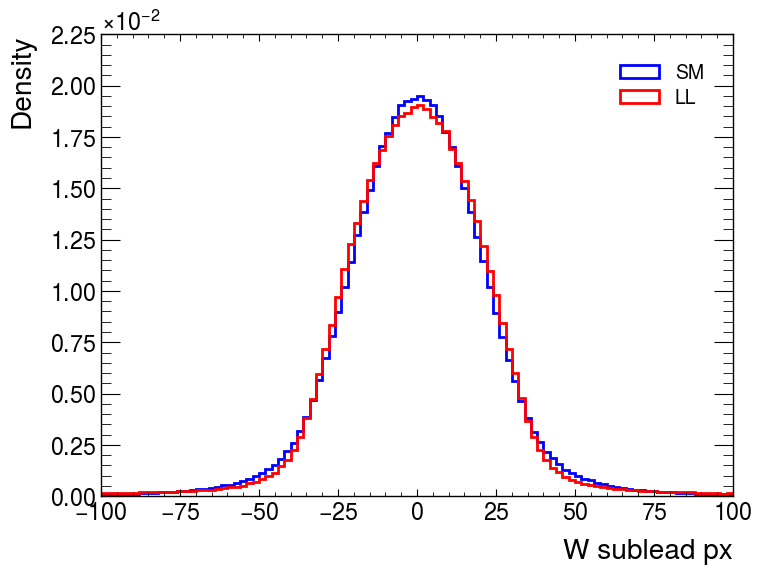

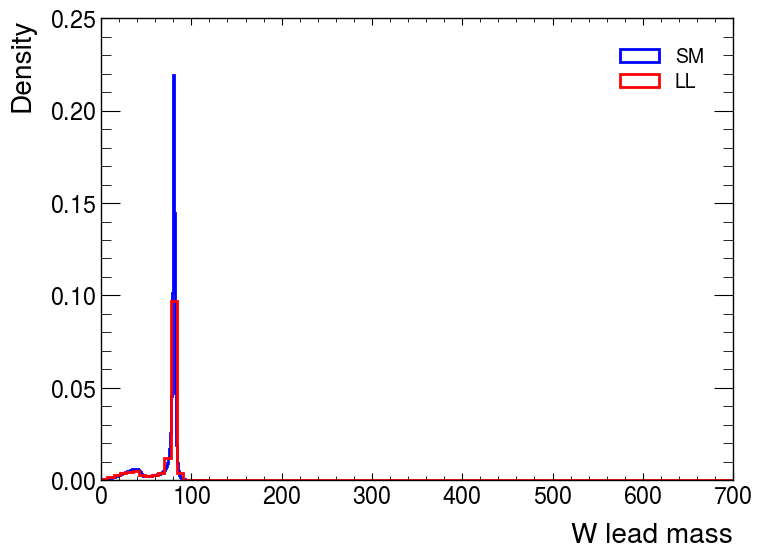

In [7]:
plt.hist(w_sublead_p4[:, 0], bins=100, range=(-100, 100), label="SM", density=True, histtype="step", linewidth=2, color='blue')
plt.hist(w_sublead_LL_p4[:, 0], bins=100, range=(-100, 100), label="LL", density=True, histtype="step", linewidth=2, color='red')
plt.xlabel("W sublead px")
plt.ylabel("Density")
plt.legend()
plt.show()

plt.hist(w_lead_m, bins=100, label="SM", density=True, histtype="step", linewidth=2, color='blue')
plt.hist(w_lead_LL_m, bins=100, label="LL", density=True, histtype="step", linewidth=2, color='red')
plt.xlabel("W lead mass")
plt.ylabel("Density")
plt.legend()
plt.show()

In [8]:
###############################################
# Truth sudy --> do not use cut at beginning! #
###############################################

print("Truth: pre-cut")
cut_pre_pt_lead = truth_lead_lep["pt"] > 22
print(len(truth_lead_lep["energy"]) - np.sum(cut_pre_pt_lead * 1))
cut_pre_pt_sub = truth_sublead_lep["pt"] > 15
print(len(truth_lead_lep["energy"]) - np.sum(cut_pre_pt_sub * 1))
cut_pre_dilep_m = (
    np.square(truth_lead_lep["energy"] + truth_sublead_lep["energy"])
    - np.square(truth_lead_lep["px"] + truth_sublead_lep["px"])
    - np.square(truth_lead_lep["py"] + truth_sublead_lep["py"])
    - np.square(truth_lead_lep["pz"] + truth_sublead_lep["pz"])
    > 10**2
)
print(len(truth_lead_lep["energy"]) - np.sum(cut_pre_dilep_m * 1))
cut_pre_pt_miss = truth_met_pt > 20
print(len(truth_lead_lep["energy"]) - np.sum(cut_pre_pt_miss * 1))
PRE_CUT = cut_pre_pt_lead & cut_pre_pt_sub & cut_pre_dilep_m & cut_pre_pt_miss
print("Total", len(truth_lead_lep["energy"]) - np.sum(PRE_CUT * 1))
del (cut_pre_pt_lead, cut_pre_pt_sub, cut_pre_dilep_m, cut_pre_pt_miss)
# print(f'''
# Check minimum cuts for each variables:
# - pt_lead: {np.min(truth_lead_lep["pt"])}
# - pt_sublead: {np.min(truth_sublead_lep["pt"])}
# - dilep_m: {np.min(np.square(truth_lead_lep["energy"] + truth_sublead_lep["energy"]) - np.square(truth_lead_lep["px"] + truth_sublead_lep["px"]) - np.square(truth_lead_lep["py"] + truth_sublead_lep["py"]) - np.square(truth_lead_lep["pz"] + truth_sublead_lep["pz"]))}
# - pt_miss: {np.min(truth_met_pt)}
# - eta_lead: {np.min(np.abs(truth_lead_lep["eta"]))}
# - eta_sublead: {np.min(np.abs(truth_sublead_lep["eta"]))}
# - phi_lead: {np.min(np.abs(truth_lead_lep["phi"]))}
# - phi_sublead: {np.min(np.abs(truth_sublead_lep["phi"]))}
# ''')

# LL
print("")
print("LL: pre-cut")
cut_pre_pt_lead = truth_lead_lep_ll["pt"] > 22
print(len(truth_lead_lep_ll["energy"]) - np.sum(cut_pre_pt_lead * 1))
cut_pre_pt_sub = truth_sublead_lep_ll["pt"] > 15
print(len(truth_lead_lep_ll["energy"]) - np.sum(cut_pre_pt_sub * 1))
cut_pre_dilep_m = (
    np.square(truth_lead_lep_ll["energy"] + truth_sublead_lep_ll["energy"])
    - np.square(truth_lead_lep_ll["px"] + truth_sublead_lep_ll["px"])
    - np.square(truth_lead_lep_ll["py"] + truth_sublead_lep_ll["py"])
    - np.square(truth_lead_lep_ll["pz"] + truth_sublead_lep_ll["pz"])
    > 10**2
)
print(len(truth_lead_lep_ll["energy"]) - np.sum(cut_pre_dilep_m * 1))
cut_pre_pt_miss = truth_met_pt_ll > 20
print(len(truth_lead_lep_ll["energy"]) - np.sum(cut_pre_pt_miss * 1))
PRE_CUT_LL = cut_pre_pt_lead & cut_pre_pt_sub & cut_pre_dilep_m & cut_pre_pt_miss
print("Total", len(truth_lead_lep_ll["energy"]) - np.sum(PRE_CUT_LL * 1))
del (cut_pre_pt_lead, cut_pre_pt_sub, cut_pre_dilep_m, cut_pre_pt_miss)
# print(f'''
# Check minimum cuts for each variables:
# - pt_lead: {np.min(truth_lead_lep_ll["pt"])}
# - pt_sublead: {np.min(truth_sublead_lep_ll["pt"])}
# - dilep_m: {np.min(np.square(truth_lead_lep_ll["energy"] + truth_sublead_lep_ll["energy"]) - np.square(truth_lead_lep_ll["px"] + truth_sublead_lep_ll["px"]) - np.square(truth_lead_lep_ll["py"] + truth_sublead_lep_ll["py"]) - np.square(truth_lead_lep_ll["pz"] + truth_sublead_lep_ll["pz"]))}
# - pt_miss: {np.min(truth_met_pt_LL)}
# - eta_lead: {np.min(np.abs(truth_lead_lep_ll["eta"]))}
# - eta_sublead: {np.min(np.abs(truth_sublead_lep_ll["eta"]))}
# - phi_lead: {np.min(np.abs(truth_lead_lep_ll["phi"]))}
# - phi_sublead: {np.min(np.abs(truth_sublead_lep_ll["phi"]))}
# ''')

Truth: pre-cut
260653
1174171
148392
287355
Total 1502903

LL: pre-cut
183962
681205
28618
242126
Total 847915


In [9]:
ROOT.gROOT.SetBatch(True)

def Bij(particles):
    def cglmp(z_xp, z_xn, z_yp, z_yn):
        """Calculate Bij (CGLMP values)."""
        tr_a = (np.divide(8, np.sqrt(3))) * (z_xp * z_xn + z_yp * z_yn)
        tr_b = 25 * (np.square(z_xp) - np.square(z_yp)) * (np.square(z_xn) - np.square(z_yn))
        tr_c = 100 * (z_xp * z_yp * z_xn * z_yn)
        return tr_a + tr_b + tr_c


    # Create 4-vectors
    WpBoson = PxPyPzEVector(*particles[:4])
    WpLepton = PxPyPzEVector(*particles[4:8])
    WnBoson = PxPyPzEVector(*particles[8:12])
    WnLepton = PxPyPzEVector(*particles[12:16])
    
    # Store lab frame
    lab_lp = np.array([WpLepton.X(), WpLepton.Y(), WpLepton.Z(), WpLepton.T()])
    lab_ln = np.array([WnLepton.X(), WnLepton.Y(), WnLepton.Z(), WnLepton.T()])
    
    # Boost to Higgs rest frame
    Higgs = WpBoson + WnBoson
    boostToHiggs = Boost(Higgs.BoostToCM())
    
    WpBoson_higgs = boostToHiggs(WpBoson)
    WpLepton_higgs = boostToHiggs(WpLepton)
    WnBoson_higgs = boostToHiggs(WnBoson)
    WnLepton_higgs = boostToHiggs(WnLepton)
    Beam_p_higgs = boostToHiggs(PxPyPzEVector(0, 0, 1, 1))

    # Define (k,r,n) basis using numpy arrays
    k_vec = np.array([WpBoson_higgs.X(), WpBoson_higgs.Y(), WpBoson_higgs.Z()])
    p_vec = np.array([Beam_p_higgs.X(), Beam_p_higgs.Y(), Beam_p_higgs.Z()])
    
    k = k_vec / np.linalg.norm(k_vec)  # unit vector
    p = p_vec / np.linalg.norm(p_vec)
    y = np.dot(p, k)
    r_length = np.sqrt(1 - y * y)
    r = (p - y * k) / r_length
    n = np.cross(p, k) / r_length
    
    # Transform to (n,r,k) basis in Higgs frame
    WpLp_higgs_vec = np.array([WpLepton_higgs.X(), WpLepton_higgs.Y(), WpLepton_higgs.Z()])
    WnLp_higgs_vec = np.array([WnLepton_higgs.X(), WnLepton_higgs.Y(), WnLepton_higgs.Z()])
    
    WpLp_higgs_nrk = np.array([np.dot(WpLp_higgs_vec, n), np.dot(WpLp_higgs_vec, r), np.dot(WpLp_higgs_vec, k)])
    WnLp_higgs_nrk = np.array([np.dot(WnLp_higgs_vec, n), np.dot(WnLp_higgs_vec, r), np.dot(WnLp_higgs_vec, k)])
    
    higgs_rest_WpLepton = np.array([*WpLp_higgs_nrk, WpLepton_higgs.E()])
    higgs_rest_WnLepton = np.array([*WnLp_higgs_nrk, WnLepton_higgs.E()])

    # Boost to W rest frames
    boostToWp = Boost(WpBoson_higgs.BoostToCM())
    boostToWn = Boost(WnBoson_higgs.BoostToCM())
    
    WpLepton_w = boostToWp(WpLepton_higgs)
    WnLepton_w = boostToWn(WnLepton_higgs)

    # Transform to (n,r,k) basis in W frames
    WpLp_w_vec = np.array([WpLepton_w.X(), WpLepton_w.Y(), WpLepton_w.Z()])
    WnLp_w_vec = np.array([WnLepton_w.X(), WnLepton_w.Y(), WnLepton_w.Z()])
    
    WpLp_w_nrk = np.array([np.dot(WpLp_w_vec, n), np.dot(WpLp_w_vec, r), np.dot(WpLp_w_vec, k)])
    WnLp_w_nrk = np.array([np.dot(WnLp_w_vec, n), np.dot(WnLp_w_vec, r), np.dot(WnLp_w_vec, k)])

    # Calculate directional cosines
    WpLp_mag = np.linalg.norm(WpLp_w_nrk)
    WnLp_mag = np.linalg.norm(WnLp_w_nrk)
    
    cos_n_join_p, cos_r_join_p, cos_k_join_p = WpLp_w_nrk / WpLp_mag
    cos_n_join_n, cos_r_join_n, cos_k_join_n = WnLp_w_nrk / WnLp_mag

    # Calculate Bij values
    B_xy = cglmp(cos_n_join_p, cos_n_join_n, cos_r_join_p, cos_r_join_n)
    B_yz = cglmp(cos_r_join_p, cos_r_join_n, cos_k_join_p, cos_k_join_n)
    B_zx = cglmp(cos_n_join_p, cos_n_join_n, cos_k_join_p, cos_k_join_n)

    w_rest_WpLepton = np.array([*WpLp_w_nrk, WpLepton_w.E()])
    w_rest_WnLepton = np.array([*WnLp_w_nrk, WnLepton_w.E()])

    return (
        np.array([B_xy, B_yz, B_zx]),
        np.array([cos_n_join_p, cos_r_join_p, cos_k_join_p]),
        np.array([cos_n_join_n, cos_r_join_n, cos_k_join_n]),
        lab_lp, lab_ln,
        higgs_rest_WpLepton, higgs_rest_WnLepton,
        w_rest_WpLepton, w_rest_WnLepton,
    )


def result_generator(particles):
    with multiprocessing.Pool(WORKERS) as pool:
        # Retrieve the output from the pool
        results = list(pool.map(Bij, particles))

    # Unpack the results
    bij, xi_p, xi_n, lab_lp, lab_ln, h_rest_lp, h_rest_ln, w_rest_lp, w_rest_ln = zip(*results)

    bij = np.vstack(bij)  # Flatten the nested array
    xi_p = np.vstack(xi_p)
    xi_n = np.vstack(xi_n)
    lab_lp = np.vstack(lab_lp)
    lab_ln = np.vstack(lab_ln)
    h_rest_lp = np.vstack(h_rest_lp)
    h_rest_ln = np.vstack(h_rest_ln)
    w_rest_lp = np.vstack(w_rest_lp)
    w_rest_ln = np.vstack(w_rest_ln)
    mask = np.any(np.isnan(bij), axis=1)
    print("Number of NaN values in bij:", np.sum(mask))
    return (
        bij,
        xi_p,
        xi_n,
        mask,
        lab_lp,
        lab_ln,
        h_rest_lp,
        h_rest_ln,
        w_rest_lp,
        w_rest_ln,
    )

In [10]:
# charged classification tag
lead_lep_is_pos = mc20_data["truth_lead_lep"]["pdgId"] > 0
lead_lep_is_pos_LL = mc20_data_LL["truth_lead_lep"]["pdgId"] > 0

In [11]:
# Assign W by charge: positive and negative

mc20_truth_pos_w_p4 = np.where(lead_lep_is_pos[:, np.newaxis], w_lead_p4, w_sublead_p4)
mc20_truth_neg_w_p4 = np.where(lead_lep_is_pos[:, np.newaxis], w_sublead_p4, w_lead_p4)
mc20_truth_pos_w_p4_LL = np.where(lead_lep_is_pos_LL[:, np.newaxis], w_lead_LL_p4, w_sublead_LL_p4)
mc20_truth_neg_w_p4_LL = np.where(lead_lep_is_pos_LL[:, np.newaxis], w_sublead_LL_p4, w_lead_LL_p4)

In [12]:
"""
CGLMP and xi:

ground truth for SM
"""

# Assign leptons by charge: positive and negative
mc20_truth_pos_lep_p4 = np.where(lead_lep_is_pos[:, np.newaxis], truth_lead_lep_p4, truth_sublead_lep_p4)
mc20_truth_neg_lep_p4 = np.where(lead_lep_is_pos[:, np.newaxis], truth_sublead_lep_p4, truth_lead_lep_p4)

mc20_particles = np.concatenate(
    [
        mc20_truth_pos_w_p4,
        mc20_truth_pos_lep_p4,
        mc20_truth_neg_w_p4,
        mc20_truth_neg_lep_p4,
    ],
    axis=1,
)
# mc20_particles = np.concatenate(
#     [
#         mc20_w_kin[:, 0:4],
#         truth_lead_lep_p4,
#         mc20_w_kin[:, 4:8],
#         truth_sublead_lep_p4,
#     ],
#     axis=1,
# )
(
    truth_bij,
    truth_xi_p,
    truth_xi_n,
    truth_mask,
    truth_lab_lp,
    truth_lab_ln,
    truth_h_rest_lp,
    truth_h_rest_ln,
    truth_w_rest_lp,
    truth_w_rest_ln,
) = result_generator(mc20_particles)

Number of NaN values in bij: 0


In [13]:
"""
CGLMP and xi:

ground truth for LL
"""

# Assign leptons by charge: positive and negative
mc20_truth_pos_lep_ll_p4 = np.where(lead_lep_is_pos_LL[:, np.newaxis], truth_lead_lep_ll_p4, truth_sublead_lep_ll_p4)
mc20_truth_neg_lep_ll_p4 = np.where(lead_lep_is_pos_LL[:, np.newaxis], truth_sublead_lep_ll_p4, truth_lead_lep_ll_p4)


mc20_particles = np.concatenate(
    [
        mc20_truth_pos_w_p4_LL,
        mc20_truth_pos_lep_ll_p4,
        mc20_truth_neg_w_p4_LL,
        mc20_truth_neg_lep_ll_p4,
    ],
    axis=1,
)
# mc20_particles = np.concatenate(
#     [
#         mc20_w_kin[:, 0:4],
#         truth_lead_lep_ll_p4,
#         mc20_w_kin[:, 4:8],
#         truth_sublead_lep_ll_p4,
#     ],
#     axis=1,
# )

(
    truth_bij_ll, 
    truth_xi_p_ll, 
    truth_xi_n_ll, 
    truth_mask_ll,
    truth_lab_lp_ll, 
    truth_lab_ln_ll,
    truth_h_rest_lp_ll, 
    truth_h_rest_ln_ll, 
    truth_w_rest_lp_ll, 
    truth_w_rest_ln_ll
) = result_generator(mc20_particles)

# truth_bij_ll_yz_mask = (truth_bij_ll[:, 1] > 10) & (truth_bij_ll[:, 1] < 20.4)
# truth_bij_ll_zx_mask = (truth_bij_ll[:, 2] > 10) & (truth_bij_ll[:, 2] < 20.4)
truth_bij_ll_yz_mask = truth_bij_ll[:, 1] > 20.4
truth_bij_ll_zx_mask = truth_bij_ll[:, 2] > 20.4

Number of NaN values in bij: 0


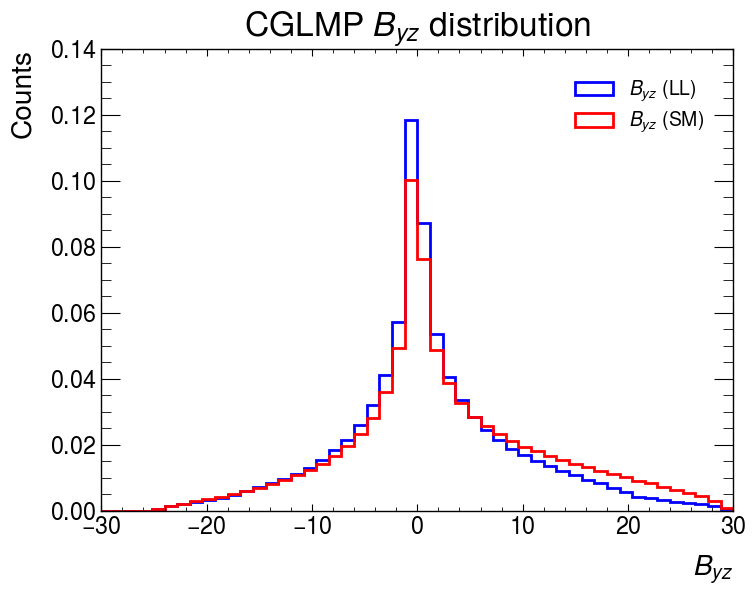

In [14]:
plt.hist(truth_bij_ll[:, 1], bins=np.linspace(-30, 30, 51), label=r"$B_{yz}$ (LL)", histtype="step", linewidth=2, color="blue", density=True)
plt.hist(truth_bij[:, 1], bins=np.linspace(-30, 30, 51), label=r"$B_{yz}$ (SM)", histtype="step", linewidth=2, color="red", density=True)
# plt.hist(truth_bij_ll[:, 1][truth_bij_ll_yz_mask], bins=np.linspace(-30, 30, 51), label=r"$B_{yz}$ (SM, LL mask)", histtype="bar", alpha=.5, color="grey")
plt.legend()
plt.xlabel(r"$B_{yz}$")
plt.ylabel("Counts")
plt.title("CGLMP $B_{yz}$ distribution")
plt.show()

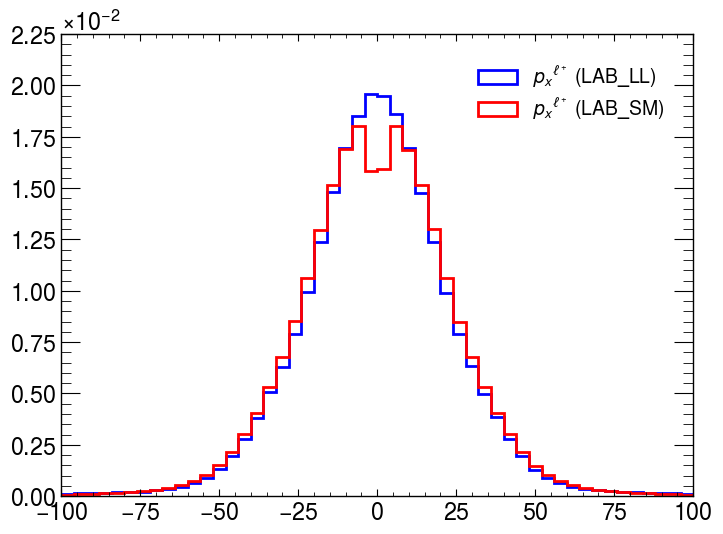

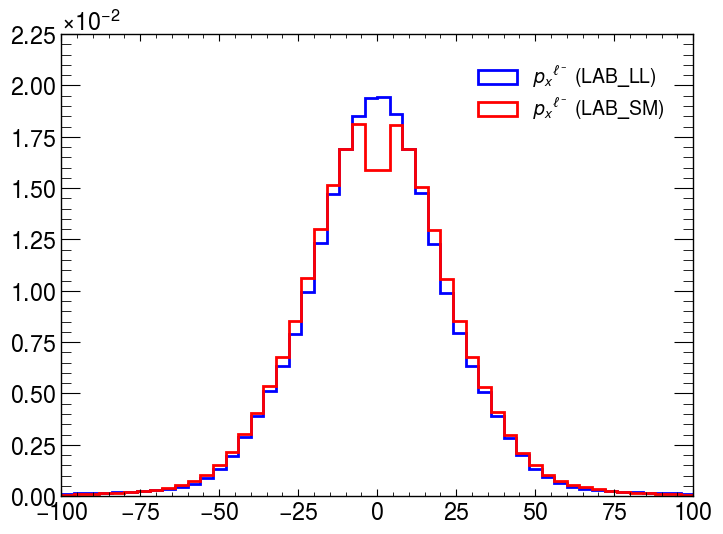

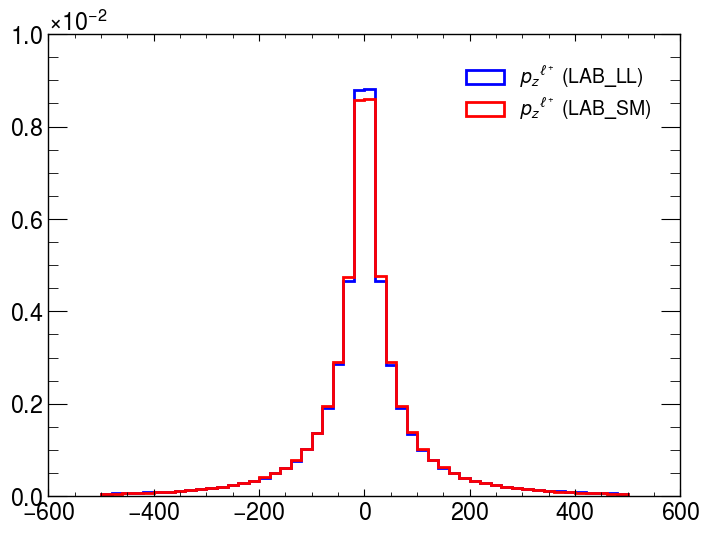

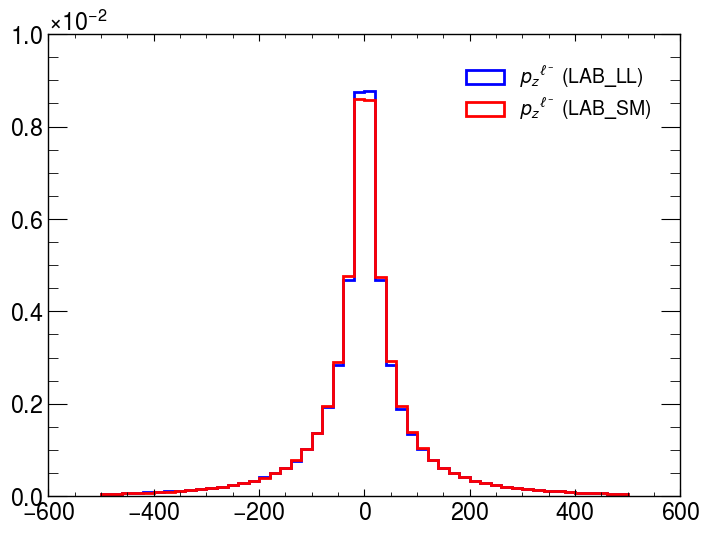

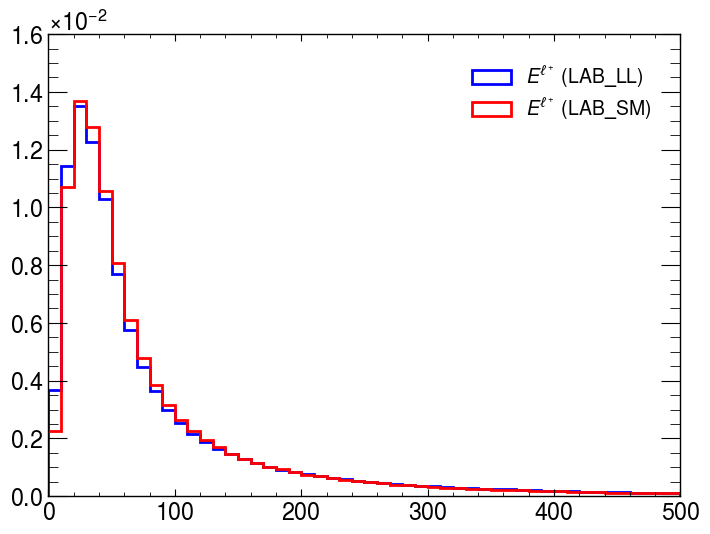

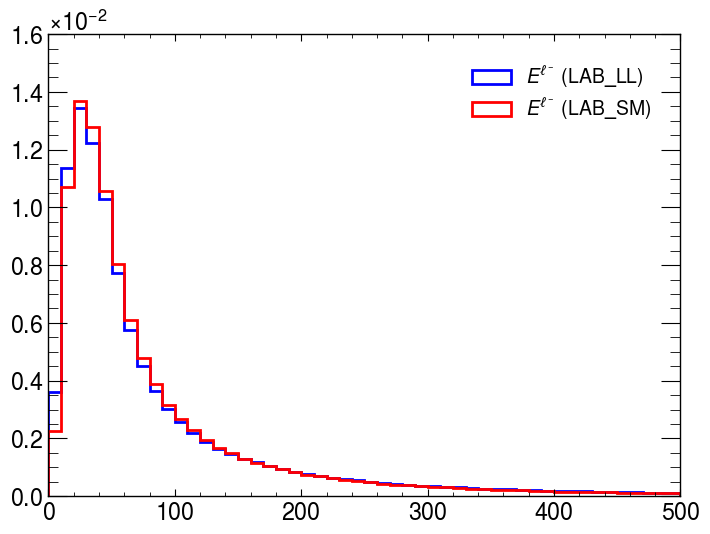

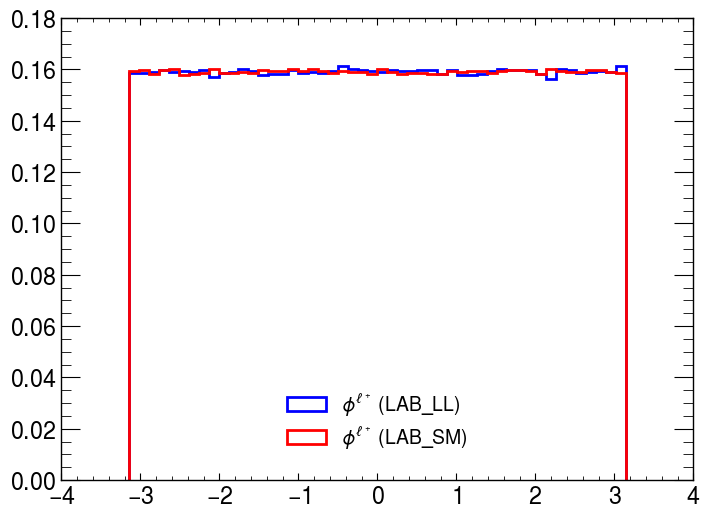

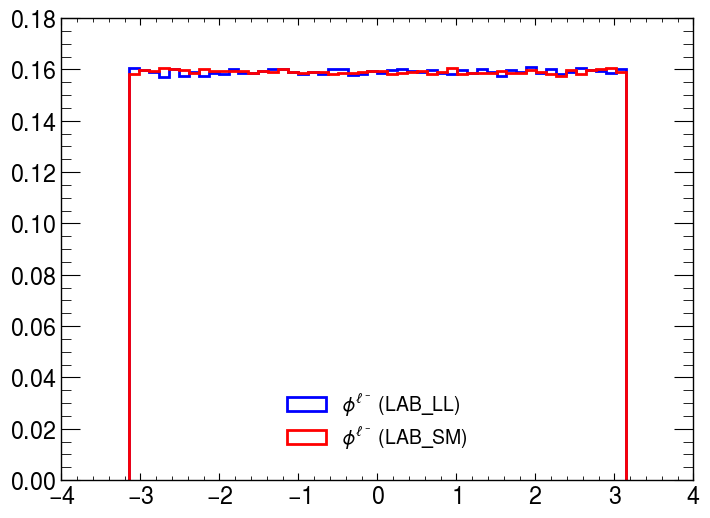

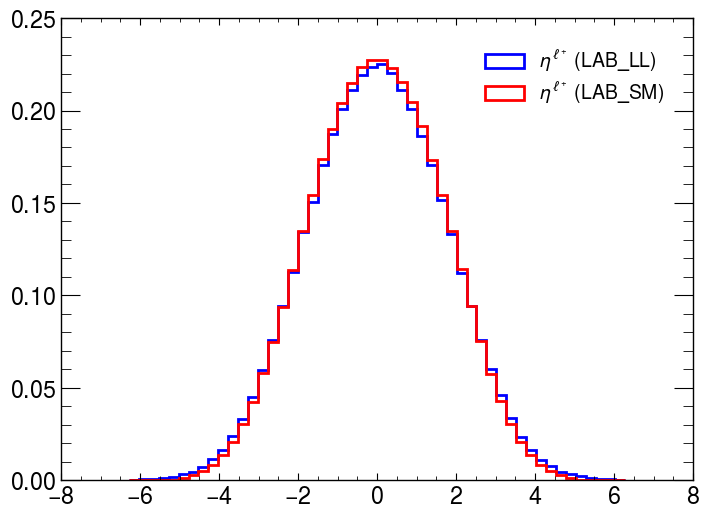

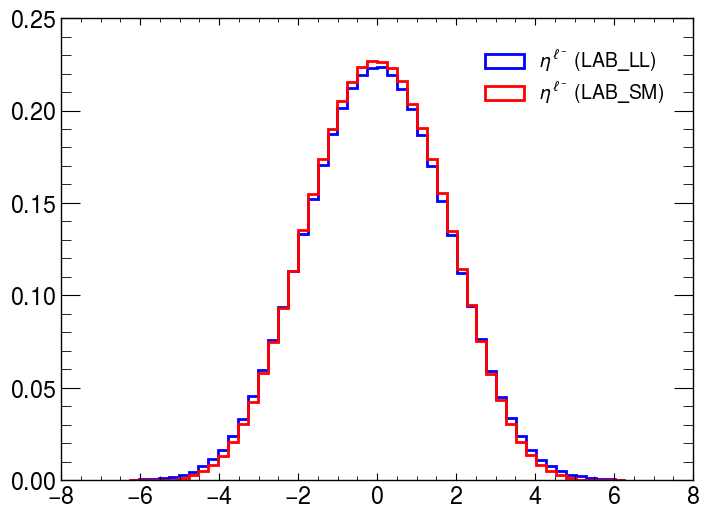

In [15]:
# Lepton kinematics in the lab frame

# Define plotting configs for each variable
plot_configs = [
    {
        "idx": 0, "range": (-100, 100), "label": r"$p_x$", "xlabel": r"$p_x$", "unit": "GeV"
    },
    {
        "idx": 2, "range": (-500, 500), "label": r"$p_z$", "xlabel": r"$p_z$", "unit": "GeV"
    },
    {
        "idx": 3, "range": (0, 500), "label": r"$E$", "xlabel": r"$E$", "unit": "GeV"
    }
]

for cfg in plot_configs:
    bins_edges = np.linspace(cfg["range"][0], cfg["range"][1], 51)
    # l0
    plt.hist(truth_lab_lp_ll[:,cfg["idx"]], bins=bins_edges, label=fr"{cfg['label']}$^{{\ell^+}}$ (LAB_LL)", histtype="step", linewidth=2, color="blue", density=True)
    plt.hist(truth_lab_lp[:,cfg["idx"]], bins=bins_edges, label=fr"{cfg['label']}$^{{\ell^+}}$ (LAB_SM)", histtype="step", linewidth=2, color="red", density=True)
    plt.legend()
    plt.show()
    # l1
    plt.hist(truth_lab_ln_ll[:,cfg["idx"]], bins=bins_edges, label=fr"{cfg['label']}$^{{\ell^-}}$ (LAB_LL)", histtype="step", linewidth=2, color="blue", density=True)
    plt.hist(truth_lab_ln[:,cfg["idx"]], bins=bins_edges, label=fr"{cfg['label']}$^{{\ell^-}}$ (LAB_SM)", histtype="step", linewidth=2, color="red", density=True)
    plt.legend()
    plt.show()
    # # 2D (l0 only)
    # plt.hist2d(truth_lab_lp_ll[:,cfg["idx"]], truth_lab_lp[:,cfg["idx"]], bins=51, range=[cfg["range"],cfg["range"]], cmap='Blues', norm=LogNorm(), cmin=1, , density=True))
    # plt.colorbar(label='Counts', )
    # plt.xlabel(fr"{cfg['label']}$^{{\ell^+}}$ (LAB_LL)")
    # plt.ylabel(fr"{cfg['label']}$^{{\ell^+}}$ (LAB_SM)")
    # plt.show()

# phi
bins_edges = np.linspace(-np.pi, np.pi, 51)
lp_phi_ll = phi(truth_lab_lp_ll[:,0], truth_lab_lp_ll[:,1])
lp_phi = phi(truth_lab_lp[:,0], truth_lab_lp[:,1])
plt.hist(lp_phi_ll, bins=bins_edges, label=r"$\phi^{\ell^+}$ (LAB_LL)", histtype="step", linewidth=2, color="blue", density=True)
plt.hist(lp_phi, bins=bins_edges, label=r"$\phi^{\ell^+}$ (LAB_SM)", histtype="step", linewidth=2, color="red", density=True)
plt.legend()
plt.show()
ln_phi_ll = phi(truth_lab_ln_ll[:,0], truth_lab_ln_ll[:,1])
ln_phi = phi(truth_lab_ln[:,0], truth_lab_ln[:,1])
plt.hist(ln_phi_ll, bins=bins_edges, label=r"$\phi^{\ell^-}$ (LAB_LL)", histtype="step", linewidth=2, color="blue", density=True)
plt.hist(ln_phi, bins=bins_edges, label=r"$\phi^{\ell^-}$ (LAB_SM)", histtype="step", linewidth=2, color="red", density=True)
plt.legend()
plt.show()
# plt.hist2d(lp_phi_ll, lp_phi, bins=51, range=[(-np.pi,np.pi),(-np.pi,np.pi)], cmap='Blues', norm=LogNorm(), cmin=1, , density=True)
# plt.colorbar(label='Counts', )
# plt.xlabel(r"$\phi^{\ell^+}$ (LAB_LL)")
# plt.ylabel(r"$\phi^{\ell^+}$ (LAB_SM)")
# plt.show()

# eta
bins_edges = np.linspace(-2*np.pi, 2*np.pi, 51)
lp_eta_ll = eta(truth_lab_lp_ll[:,0], truth_lab_lp_ll[:,1], truth_lab_lp_ll[:,2])
lp_eta = eta(truth_lab_lp[:,0], truth_lab_lp[:,1], truth_lab_lp[:,2])
plt.hist(lp_eta_ll, bins=bins_edges, label=r"$\eta^{\ell^+}$ (LAB_LL)", histtype="step", linewidth=2, color="blue", density=True)
plt.hist(lp_eta, bins=bins_edges, label=r"$\eta^{\ell^+}$ (LAB_SM)", histtype="step", linewidth=2, color="red", density=True)
plt.legend()
plt.show()
# plt.hist2d(lp_eta_ll, lp_eta, bins=51, range=[(-2*np.pi,2*np.pi),(-2*np.pi,2*np.pi)], cmap='Blues', norm=LogNorm(), cmin=1, , density=True)
# plt.colorbar(label='Counts', )
# plt.xlabel(r"$\eta^{\ell^+}$ (LAB_LL)")
# plt.ylabel(r"$\eta^{\ell^+}$ (LAB_SM)")
# plt.show()
ln_eta_ll = eta(truth_lab_ln_ll[:,0], truth_lab_ln_ll[:,1], truth_lab_ln_ll[:,2])
ln_eta = eta(truth_lab_ln[:,0], truth_lab_ln[:,1], truth_lab_ln[:,2])
plt.hist(ln_eta_ll, bins=bins_edges, label=r"$\eta^{\ell^-}$ (LAB_LL)", histtype="step", linewidth=2, color="blue", density=True)
plt.hist(ln_eta, bins=bins_edges, label=r"$\eta^{\ell^-}$ (LAB_SM)", histtype="step", linewidth=2, color="red", density=True)
plt.legend()
plt.show()

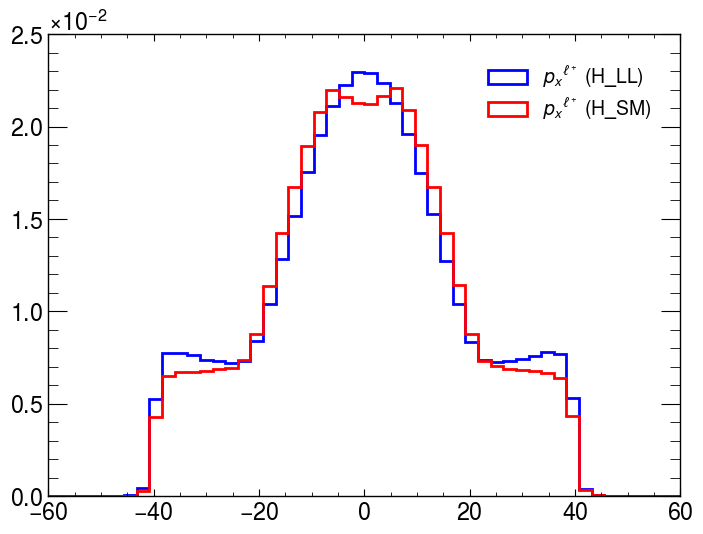

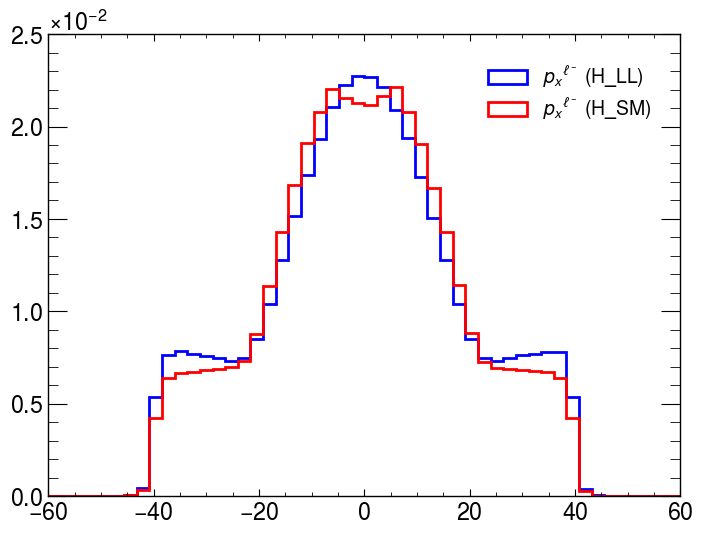

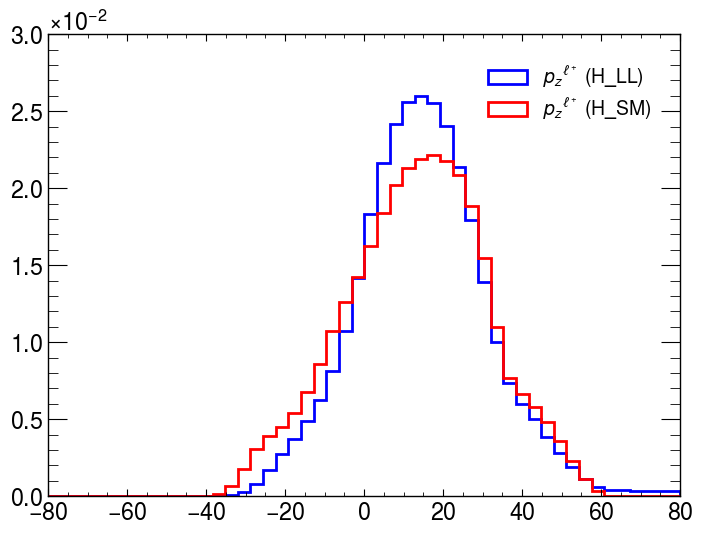

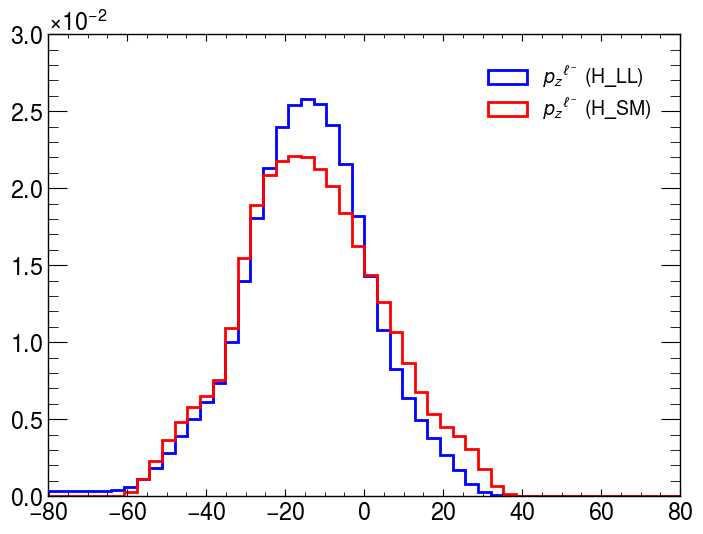

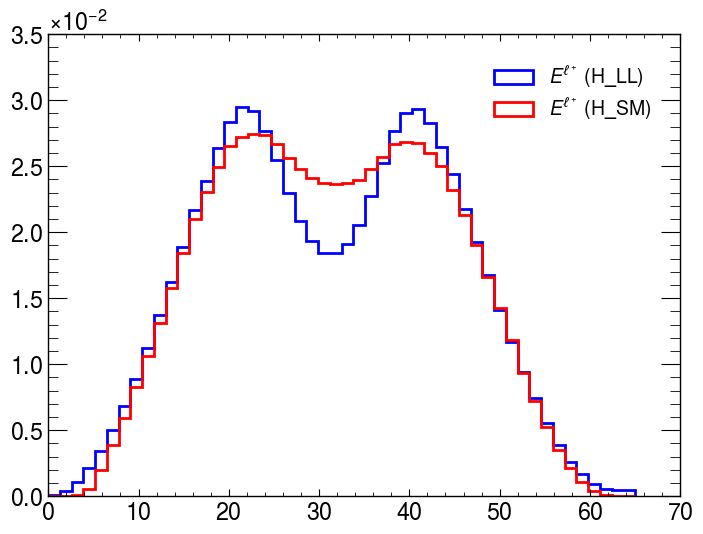

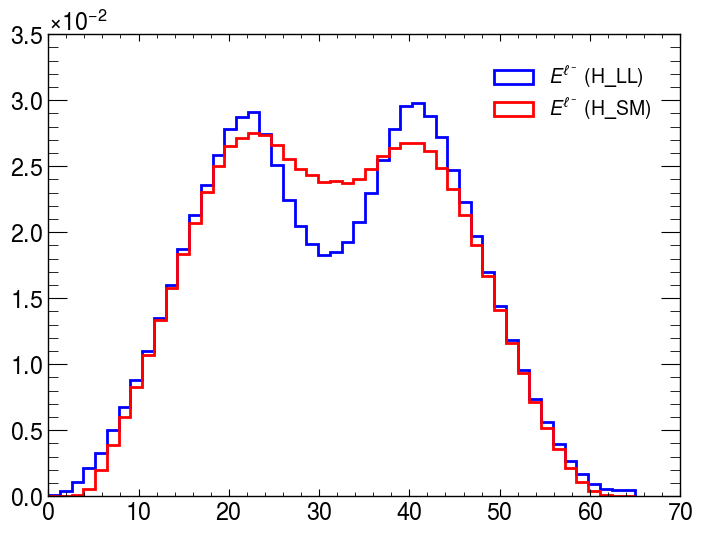

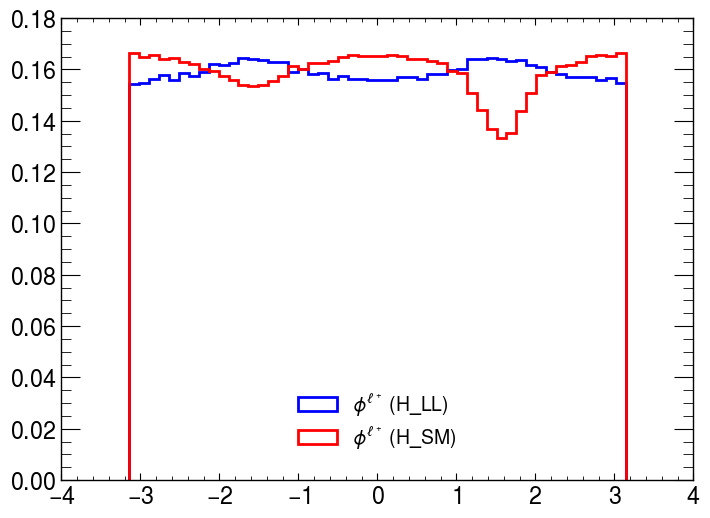

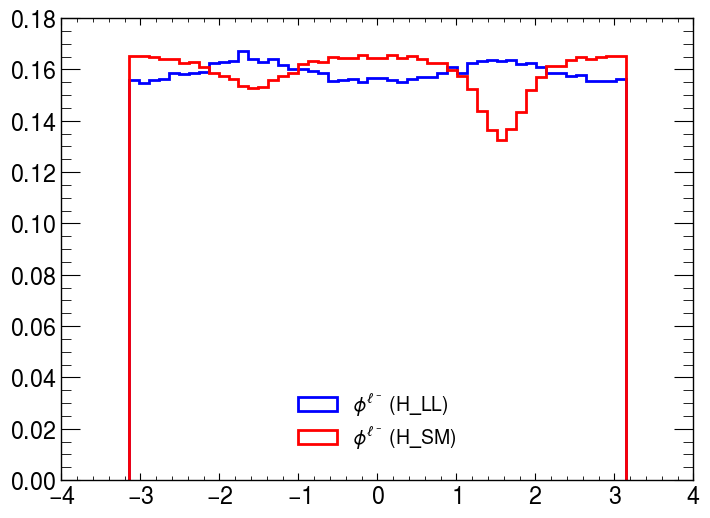

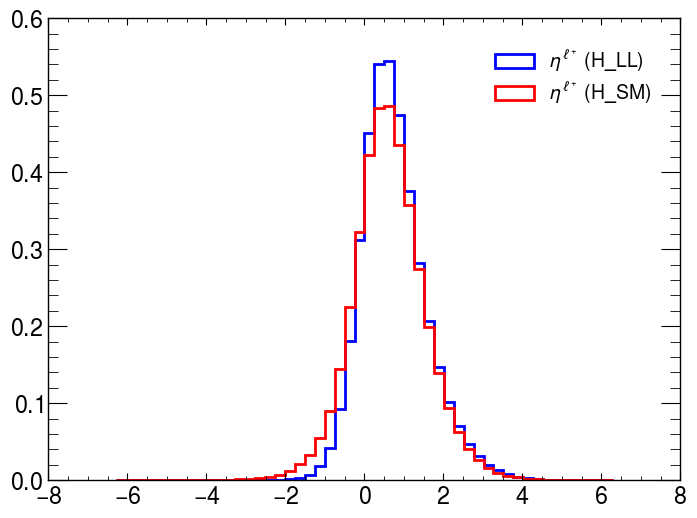

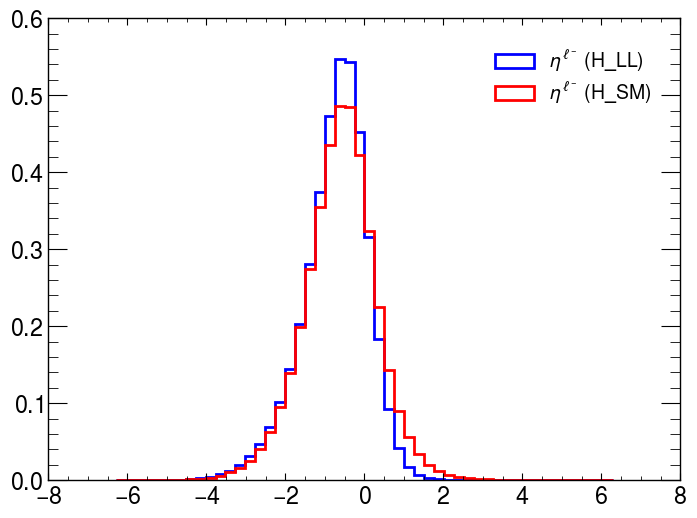

In [16]:
# Lepton kinematics in the Higgs rest frame
# Define plotting configs for each variable in the Higgs rest frame
plot_configs = [
    {
        "idx": 0, "range": (-60, 60), "label": r"$p_x$", "xlabel": r"$p_x$", "unit": "GeV"
    },
    {
        "idx": 2, "range": (-80, 80), "label": r"$p_z$", "xlabel": r"$p_z$", "unit": "GeV"
    },
    {
        "idx": 3, "range": (0, 65), "label": r"$E$", "xlabel": r"$E$", "unit": "GeV"
    }
]

for cfg in plot_configs:
    bins_edges = np.linspace(cfg["range"][0], cfg["range"][1], 51)
    # l0
    plt.hist(truth_h_rest_lp_ll[:,cfg["idx"]], bins=bins_edges, label=fr"{cfg['label']}$^{{\ell^+}}$ (H_LL)", histtype="step", linewidth=2, color="blue", density=True)
    plt.hist(truth_h_rest_lp[:,cfg["idx"]], bins=bins_edges, label=fr"{cfg['label']}$^{{\ell^+}}$ (H_SM)", histtype="step", linewidth=2, color="red", density=True)
    plt.legend()
    plt.show()
    # l1
    plt.hist(truth_h_rest_ln_ll[:,cfg["idx"]], bins=bins_edges, label=fr"{cfg['label']}$^{{\ell^-}}$ (H_LL)", histtype="step", linewidth=2, color="blue", density=True)
    plt.hist(truth_h_rest_ln[:,cfg["idx"]], bins=bins_edges, label=fr"{cfg['label']}$^{{\ell^-}}$ (H_SM)", histtype="step", linewidth=2, color="red", density=True)
    plt.legend()
    plt.show()
    # # 2D (l0 only)
    # plt.hist2d(truth_h_rest_lp_ll[:,cfg["idx"]], truth_h_rest_lp[:,cfg["idx"]], bins=51, range=[cfg["range"],cfg["range"]], cmap='Blues', norm=LogNorm(), cmin=1, , density=True)
    # plt.colorbar(label='Counts', )
    # plt.xlabel(fr"{cfg['label']}$^{{\ell^+}}$ (H_LL)")
    # plt.ylabel(fr"{cfg['label']}$^{{\ell^+}}$ (H_SM)")
    # plt.show()

# phi
bins_edges = np.linspace(-np.pi, np.pi, 51)
lp_phi_ll = phi(truth_h_rest_lp_ll[:,0], truth_h_rest_lp_ll[:,1])
lp_phi = phi(truth_h_rest_lp[:,0], truth_h_rest_lp[:,1])
plt.hist(lp_phi_ll, bins=bins_edges, label=r"$\phi^{\ell^+}$ (H_LL)", histtype="step", linewidth=2, color="blue", density=True)
plt.hist(lp_phi, bins=bins_edges, label=r"$\phi^{\ell^+}$ (H_SM)", histtype="step", linewidth=2, color="red", density=True)
plt.legend()
plt.show()
ln_phi_ll = phi(truth_h_rest_ln_ll[:,0], truth_h_rest_ln_ll[:,1])
ln_phi = phi(truth_h_rest_ln[:,0], truth_h_rest_ln[:,1])
plt.hist(ln_phi_ll, bins=bins_edges, label=r"$\phi^{\ell^-}$ (H_LL)", histtype="step", linewidth=2, color="blue", density=True)
plt.hist(ln_phi, bins=bins_edges, label=r"$\phi^{\ell^-}$ (H_SM)", histtype="step", linewidth=2, color="red", density=True)
plt.legend()
plt.show()
# # 2D (l0 only)
# plt.hist2d(lp_phi_ll, lp_phi, bins=51, range=[(-np.pi,np.pi),(-np.pi,np.pi)], cmap='Blues', norm=LogNorm(), cmin=1, , density=True)
# plt.colorbar(label='Counts', )
# plt.xlabel(r"$\phi^{\ell^+}$ (H_LL)")
# plt.ylabel(r"$\phi^{\ell^+}$ (H_SM)")
# plt.show()

# eta
bins_edges = np.linspace(-2*np.pi, 2*np.pi, 51)
lp_eta_ll = eta(truth_h_rest_lp_ll[:,0], truth_h_rest_lp_ll[:,1], truth_h_rest_lp_ll[:,2])
lp_eta = eta(truth_h_rest_lp[:,0], truth_h_rest_lp[:,1], truth_h_rest_lp[:,2])
plt.hist(lp_eta_ll, bins=bins_edges, label=r"$\eta^{\ell^+}$ (H_LL)", histtype="step", linewidth=2, color="blue", density=True)
plt.hist(lp_eta, bins=bins_edges, label=r"$\eta^{\ell^+}$ (H_SM)", histtype="step", linewidth=2, color="red", density=True)
plt.legend()
plt.show()
ln_eta_ll = eta(truth_h_rest_ln_ll[:,0], truth_h_rest_ln_ll[:,1], truth_h_rest_ln_ll[:,2])
ln_eta = eta(truth_h_rest_ln[:,0], truth_h_rest_ln[:,1], truth_h_rest_ln[:,2])
plt.hist(ln_eta_ll, bins=bins_edges, label=r"$\eta^{\ell^-}$ (H_LL)", histtype="step", linewidth=2, color="blue", density=True)
plt.hist(ln_eta, bins=bins_edges, label=r"$\eta^{\ell^-}$ (H_SM)", histtype="step", linewidth=2, color="red", density=True)
plt.legend()
plt.show()
# # 2D (l0 only)
# plt.hist2d(lp_eta_ll, lp_eta, bins=51, range=[(-2*np.pi,2*np.pi),(-2*np.pi,2*np.pi)], cmap='Blues', norm=LogNorm(), cmin=1, , density=True)
# plt.colorbar(label='Counts', )
# plt.xlabel(r"$\eta^{\ell^+}$ (H_LL)")
# plt.ylabel(r"$\eta^{\ell^+}$ (H_SM)")
# plt.show()

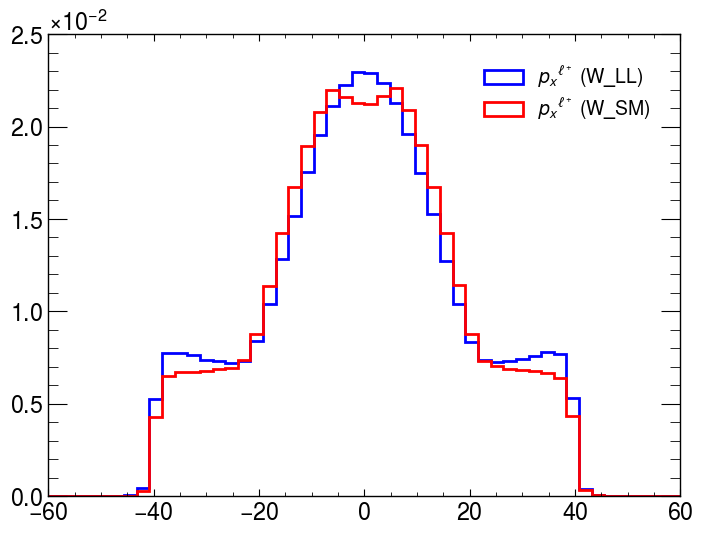

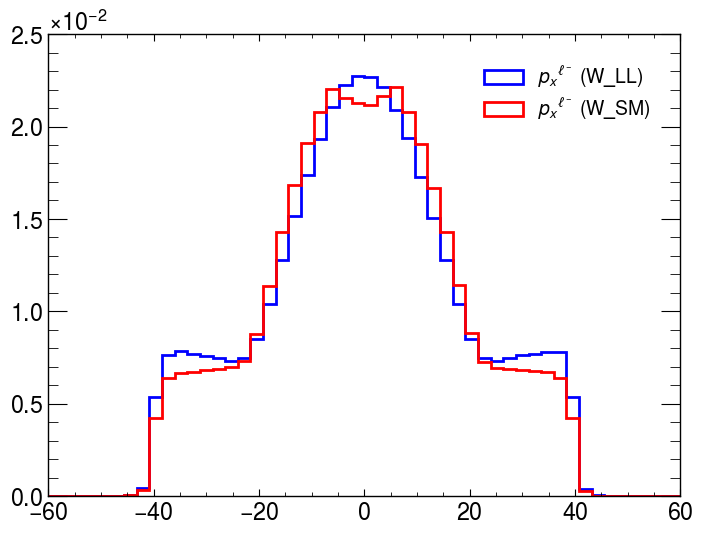

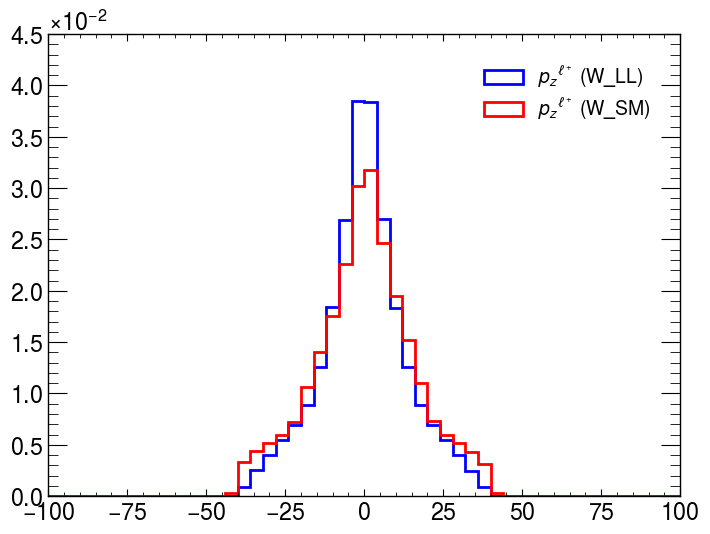

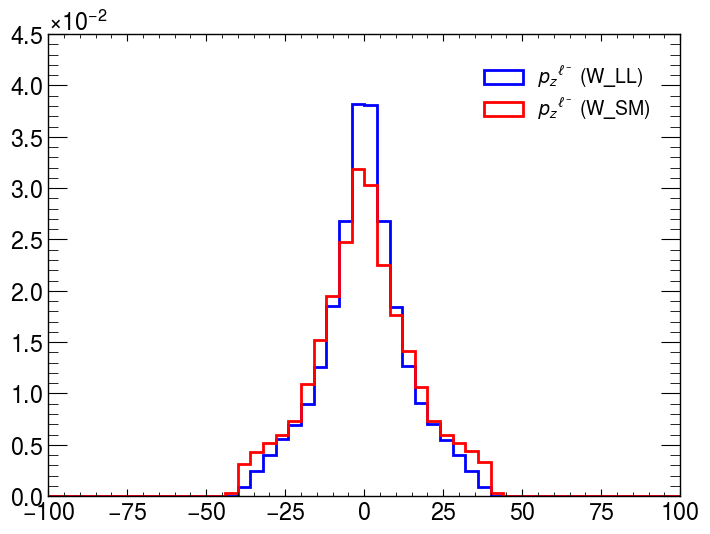

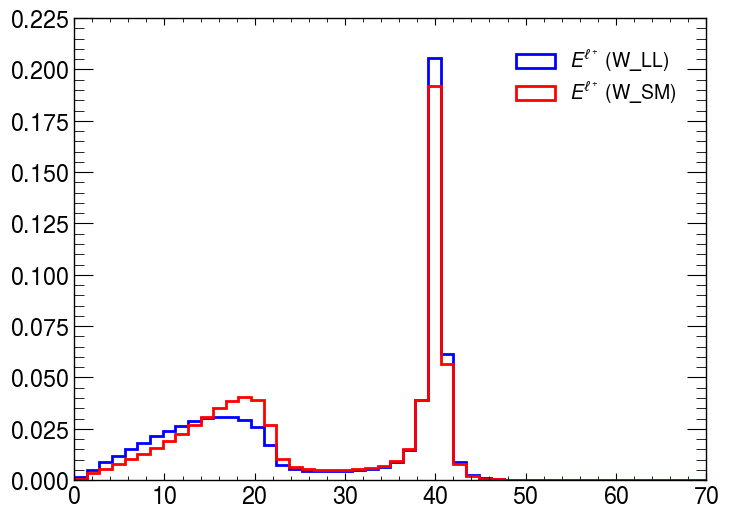

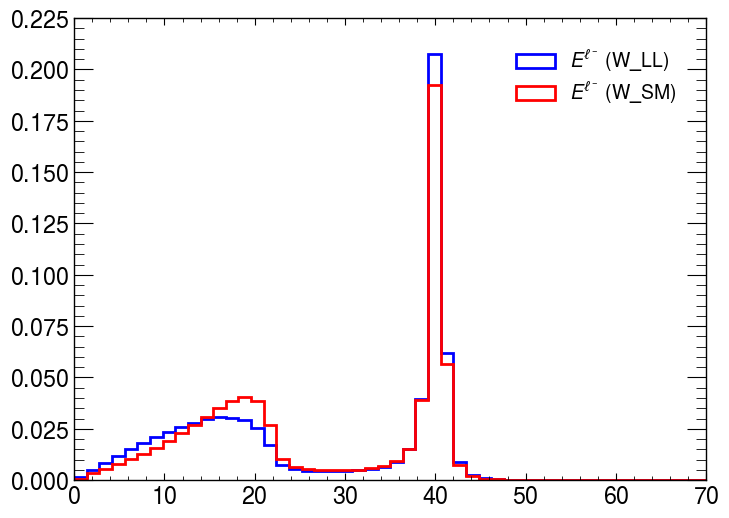

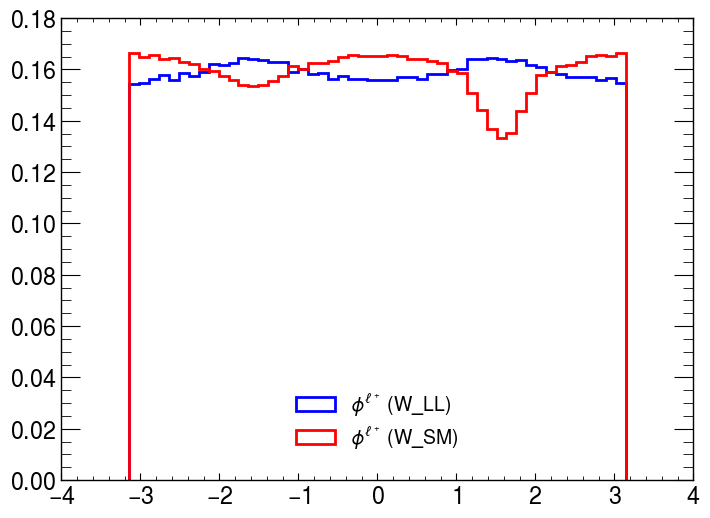

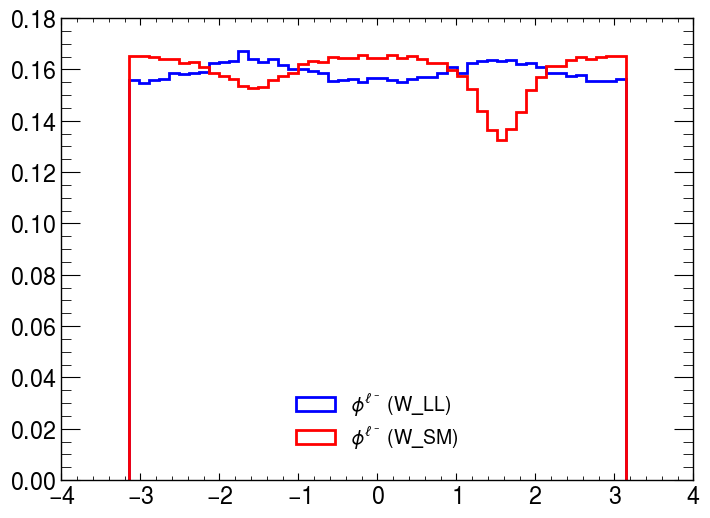

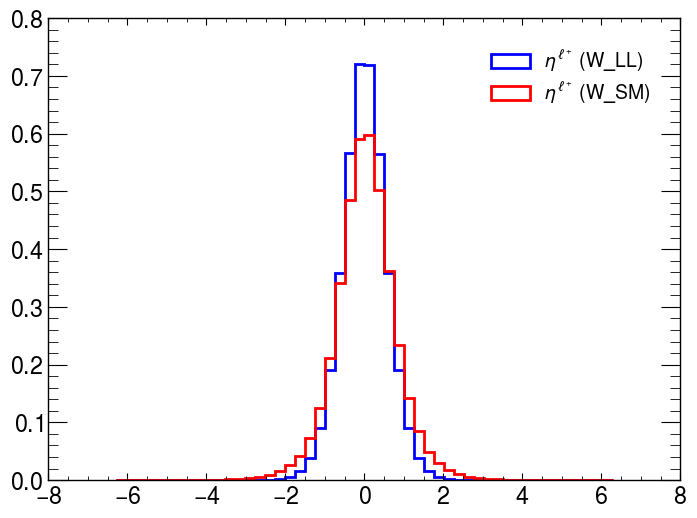

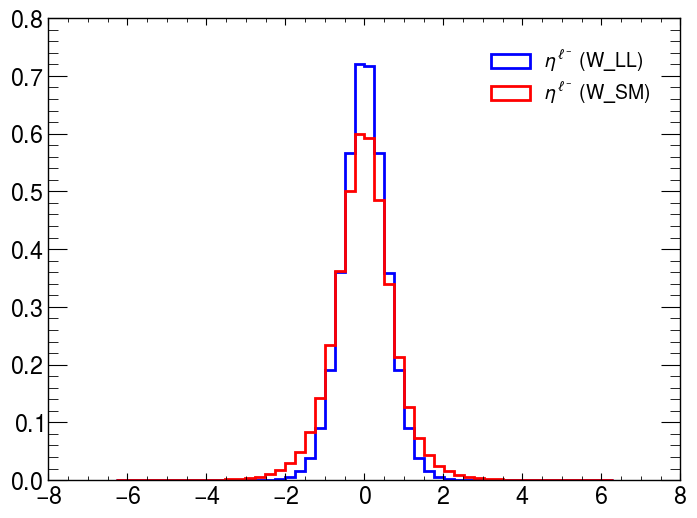

In [17]:
# Lepton kinematics in the Higgs rest frame
# Define plotting configs for each variable in the Higgs rest frame
plot_configs = [
    {
        "idx": 0, "range": (-60, 60), "label": r"$p_x$", "xlabel": r"$p_x$", "unit": "GeV"
    },
    {
        "idx": 2, "range": (-100, 100), "label": r"$p_z$", "xlabel": r"$p_z$", "unit": "GeV"
    },
    {
        "idx": 3, "range": (0, 70), "label": r"$E$", "xlabel": r"$E$", "unit": "GeV"
    }
]

for cfg in plot_configs:
    bins_edges = np.linspace(cfg["range"][0], cfg["range"][1], 51)
    # l0
    plt.hist(truth_w_rest_lp_ll[:,cfg["idx"]], bins=bins_edges, label=fr"{cfg['label']}$^{{\ell^+}}$ (W_LL)", histtype="step", linewidth=2, color="blue", density=True)
    plt.hist(truth_w_rest_lp[:,cfg["idx"]], bins=bins_edges, label=fr"{cfg['label']}$^{{\ell^+}}$ (W_SM)", histtype="step", linewidth=2, color="red", density=True)
    plt.legend()
    plt.show()
    # l1
    plt.hist(truth_w_rest_ln_ll[:,cfg["idx"]], bins=bins_edges, label=fr"{cfg['label']}$^{{\ell^-}}$ (W_LL)", histtype="step", linewidth=2, color="blue", density=True)
    plt.hist(truth_w_rest_ln[:,cfg["idx"]], bins=bins_edges, label=fr"{cfg['label']}$^{{\ell^-}}$ (W_SM)", histtype="step", linewidth=2, color="red", density=True)
    plt.legend()
    plt.show()
    # # 2D (l0 only)
    # plt.hist2d(truth_w_rest_lp_ll[:,cfg["idx"]], truth_w_rest_lp[:,cfg["idx"]], bins=51, range=[cfg["range"],cfg["range"]], cmap='Blues', norm=LogNorm(), cmin=1, , density=True)
    # plt.colorbar(label='Counts', )
    # plt.xlabel(fr"{cfg['label']}$^{{\ell^+}}$ (W_LL)")
    # plt.ylabel(fr"{cfg['label']}$^{{\ell^+}}$ (W_SM)")
    # plt.show()

# phi
bins_edges = np.linspace(-np.pi, np.pi, 51)
lp_phi_ll = phi(truth_w_rest_lp_ll[:,0], truth_w_rest_lp_ll[:,1])
lp_phi = phi(truth_w_rest_lp[:,0], truth_w_rest_lp[:,1])
plt.hist(lp_phi_ll, bins=bins_edges, label=r"$\phi^{\ell^+}$ (W_LL)", histtype="step", linewidth=2, color="blue", density=True)
plt.hist(lp_phi, bins=bins_edges, label=r"$\phi^{\ell^+}$ (W_SM)", histtype="step", linewidth=2, color="red", density=True)
plt.legend()
plt.show()
ln_phi_ll = phi(truth_w_rest_ln_ll[:,0], truth_w_rest_ln_ll[:,1])
ln_phi = phi(truth_w_rest_ln[:,0], truth_w_rest_ln[:,1])
plt.hist(ln_phi_ll, bins=bins_edges, label=r"$\phi^{\ell^-}$ (W_LL)", histtype="step", linewidth=2, color="blue", density=True)
plt.hist(ln_phi, bins=bins_edges, label=r"$\phi^{\ell^-}$ (W_SM)", histtype="step", linewidth=2, color="red", density=True)
plt.legend()
plt.show()
# # 2D (l0 only)
# plt.hist2d(lp_phi_ll, lp_phi, bins=51, range=[(-np.pi,np.pi),(-np.pi,np.pi)], cmap='Blues', norm=LogNorm(), cmin=1, , density=True)
# plt.colorbar(label='Counts', )
# plt.xlabel(r"$\phi^{\ell^+}$ (W_LL)")
# plt.ylabel(r"$\phi^{\ell^+}$ (W_SM)")
# plt.show()

# eta
bins_edges = np.linspace(-2*np.pi, 2*np.pi, 51)
lp_eta_ll = eta(truth_w_rest_lp_ll[:,0], truth_w_rest_lp_ll[:,1], truth_w_rest_lp_ll[:,2])
lp_eta = eta(truth_w_rest_lp[:,0], truth_w_rest_lp[:,1], truth_w_rest_lp[:,2])
plt.hist(lp_eta_ll, bins=bins_edges, label=r"$\eta^{\ell^+}$ (W_LL)", histtype="step", linewidth=2, color="blue", density=True)
plt.hist(lp_eta, bins=bins_edges, label=r"$\eta^{\ell^+}$ (W_SM)", histtype="step", linewidth=2, color="red", density=True)
plt.legend()
plt.show()
ln_eta_ll = eta(truth_w_rest_ln_ll[:,0], truth_w_rest_ln_ll[:,1], truth_w_rest_ln_ll[:,2])
ln_eta = eta(truth_w_rest_ln[:,0], truth_w_rest_ln[:,1], truth_w_rest_ln[:,2])
plt.hist(ln_eta_ll, bins=bins_edges, label=r"$\eta^{\ell^-}$ (W_LL)", histtype="step", linewidth=2, color="blue", density=True)
plt.hist(ln_eta, bins=bins_edges, label=r"$\eta^{\ell^-}$ (W_SM)", histtype="step", linewidth=2, color="red", density=True)
plt.legend()
plt.show()
# # 2D (l0 only)
# plt.hist2d(lp_eta_ll, lp_eta, bins=51, range=[(-2*np.pi,2*np.pi),(-2*np.pi,2*np.pi)], cmap='Blues', norm=LogNorm(), cmin=1, , density=True)
# plt.colorbar(label='Counts', )
# plt.xlabel(r"$\eta^{\ell^+}$ (W_LL)")
# plt.ylabel(r"$\eta^{\ell^+}$ (W_SM)")
# plt.show()

# # cosine theta
# bins_edges = np.linspace(-1, 1, 51)
# lp_cos_theta_ll = np.cos(np.arctan2(truth_w_rest_lp_ll[:,1], truth_w_rest_lp_ll[:,0]))
# lp_cos_theta = np.cos(np.arctan2(truth_w_rest_lp[:,1], truth_w_rest_lp[:,0]))
# plt.hist(lp_cos_theta_ll, bins=bins_edges, label=r"$\cos(\theta^{\ell^+})$ (W_LL)", histtype="step", linewidth=2, color="blue", density=True)
# plt.hist(lp_cos_theta, bins=bins_edges, label=r"$\cos(\theta^{\ell^+})$ (W_SM)", histtype="step", linewidth=2, color="red", density=True)
# plt.legend()
# plt.show()
# ln_cos_theta_ll = np.cos(np.arctan2(truth_w_rest_ln_ll[:,1], truth_w_rest_ln_ll[:,0]))
# ln_cos_theta = np.cos(np.arctan2(truth_w_rest_ln[:,1], truth_w_rest_ln[:,0]))
# plt.hist(ln_cos_theta_ll, bins=bins_edges, label=r"$\cos(\theta^{\ell^-})$ (W_LL)", histtype="step", linewidth=2, color="blue", density=True)
# plt.hist(ln_cos_theta, bins=bins_edges, label=r"$\cos(\theta^{\ell^-})$ (W_SM)", histtype="step", linewidth=2, color="red", density=True)
# plt.legend()
# plt.show()
# # 2D (l0 only)
# plt.hist2d(lp_cos_theta_ll, lp_cos_theta, bins=51, range=[(-1,1),(-1,1)], cmap='Blues', norm=LogNorm(), cmin=1, , density=True)
# plt.colorbar(label='Counts', )
# plt.xlabel(r"$\cos(\theta^{\ell^+})$ (W_LL)")
# plt.ylabel(r"$\cos(\theta^{\ell^+})$ (W_SM)")
# plt.show()

In [18]:
# variables for plotting

truth_bij = truth_bij
truth_bij_ll = truth_bij_ll
truth_xi_p = truth_xi_p
truth_xi_p_ll = truth_xi_p_ll
truth_xi_n = truth_xi_n
truth_xi_n_ll = truth_xi_n_ll

LL (ground truth) vs SM (ground truth)


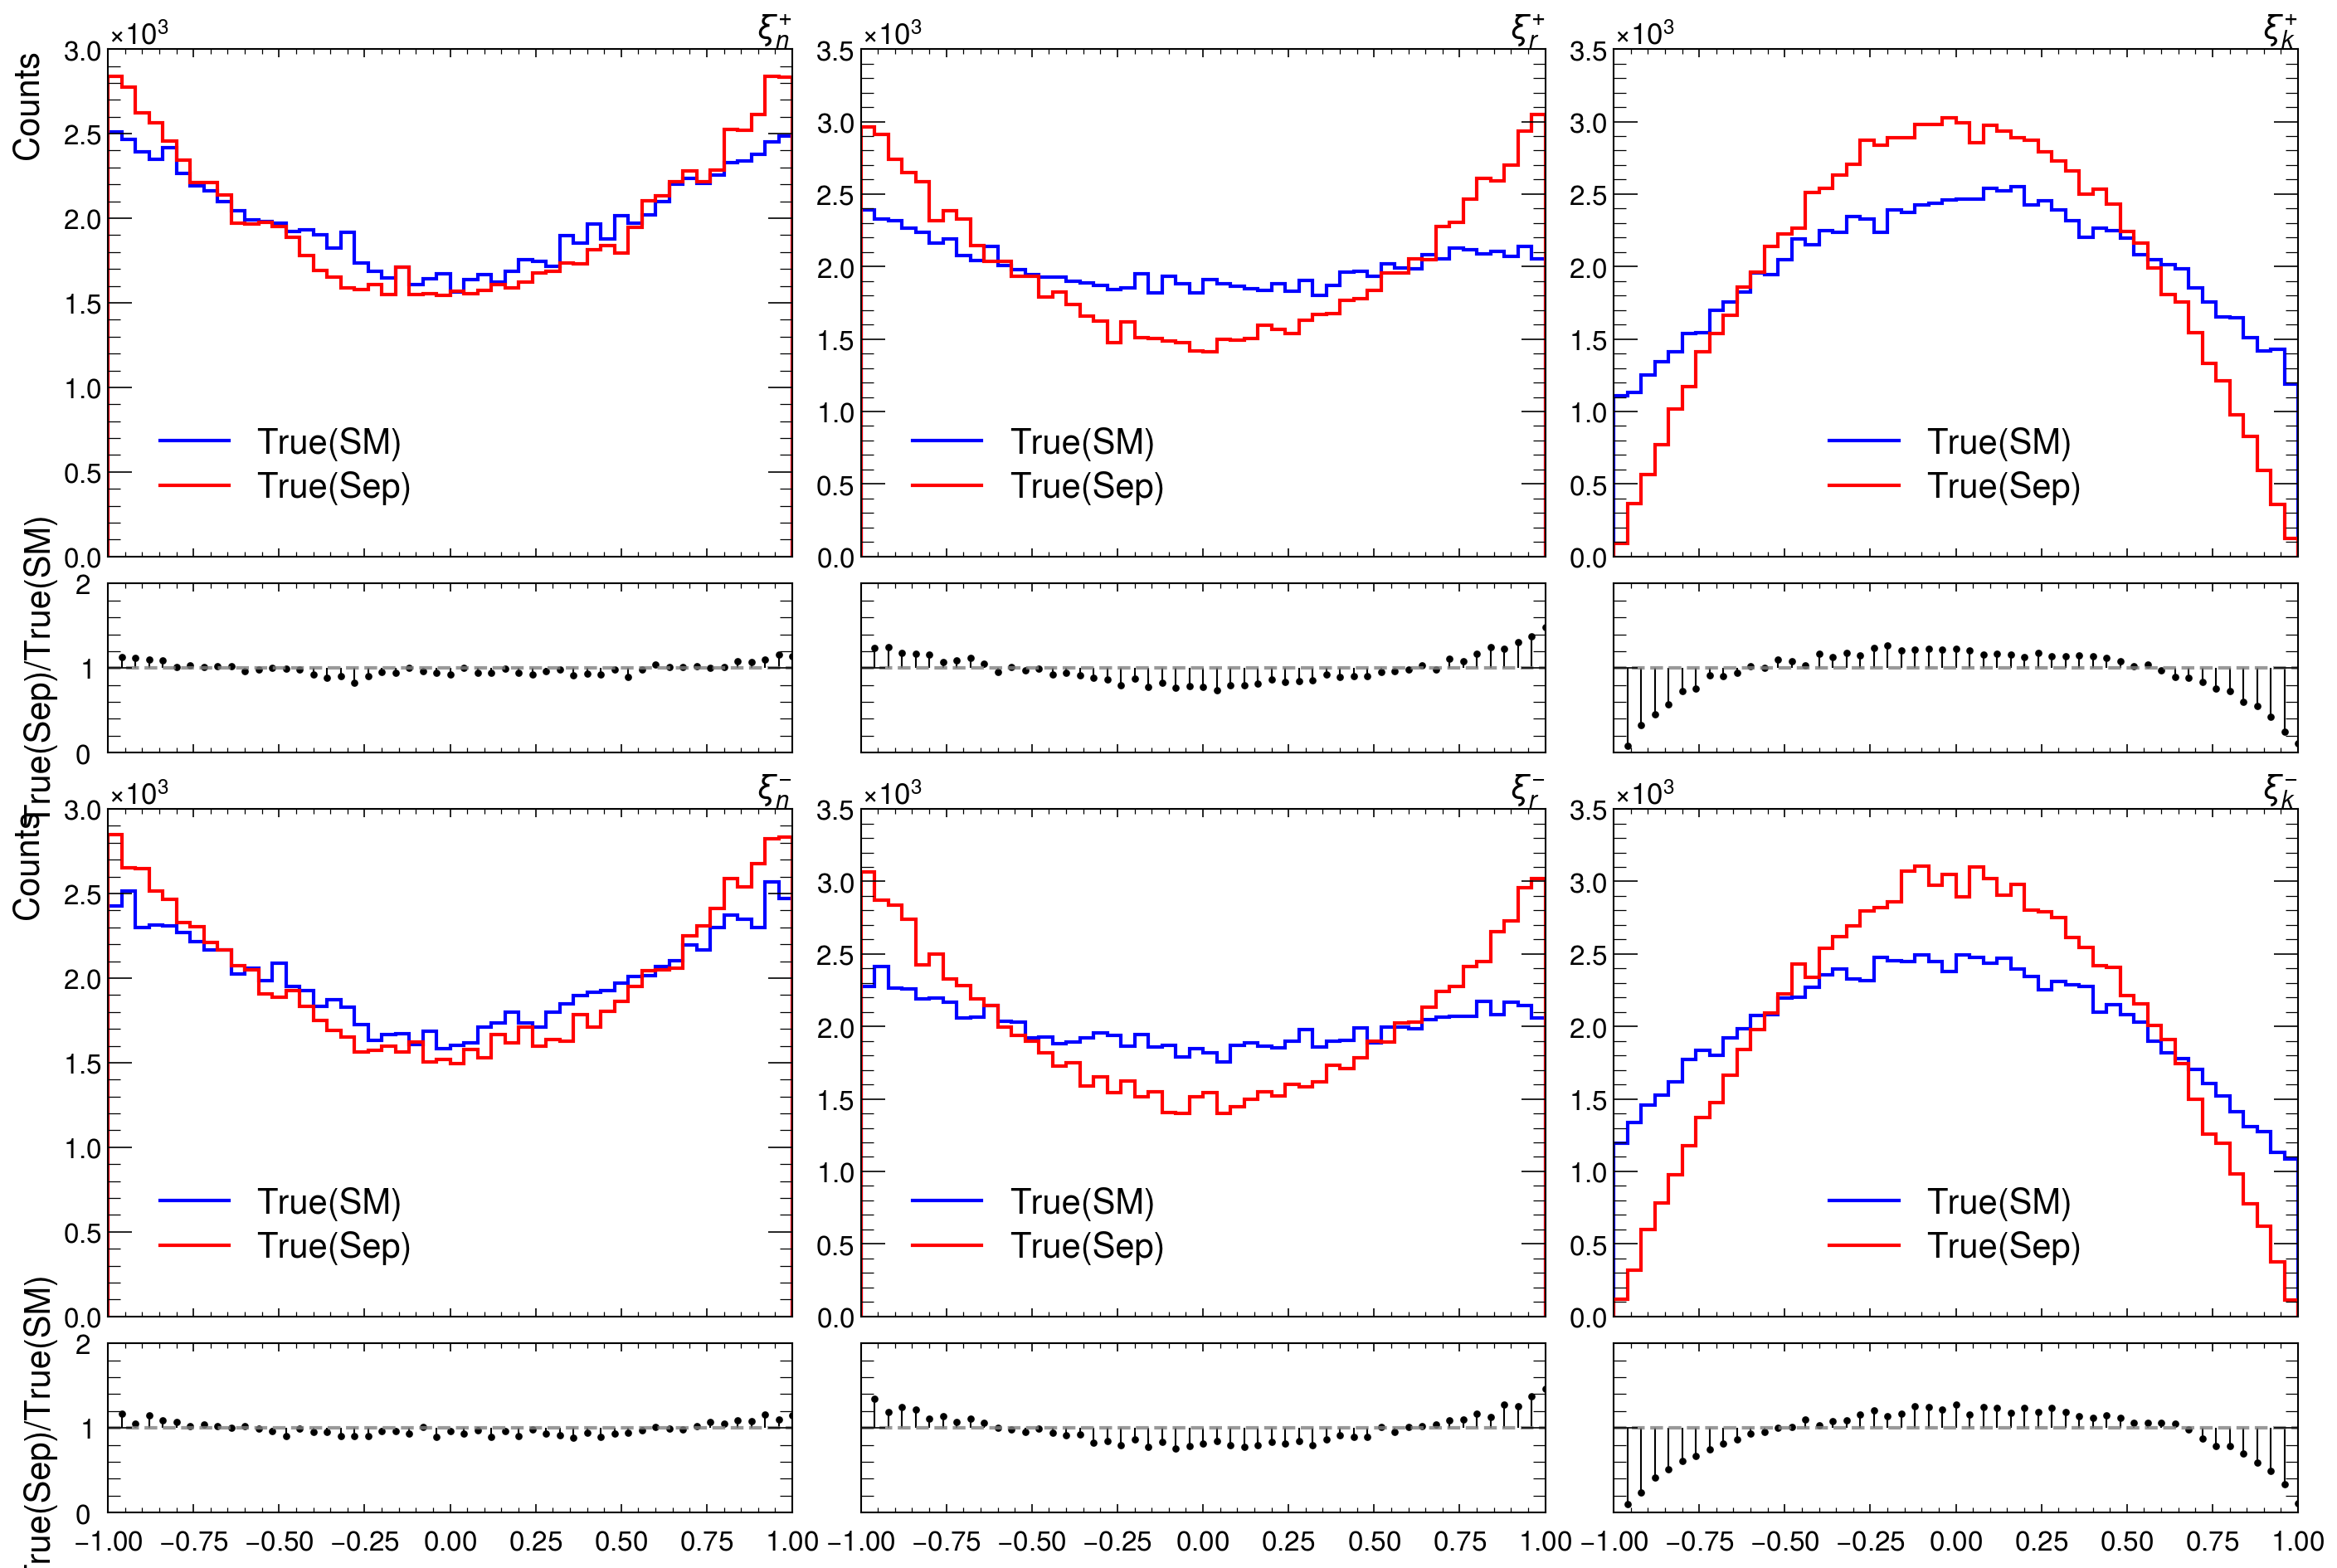

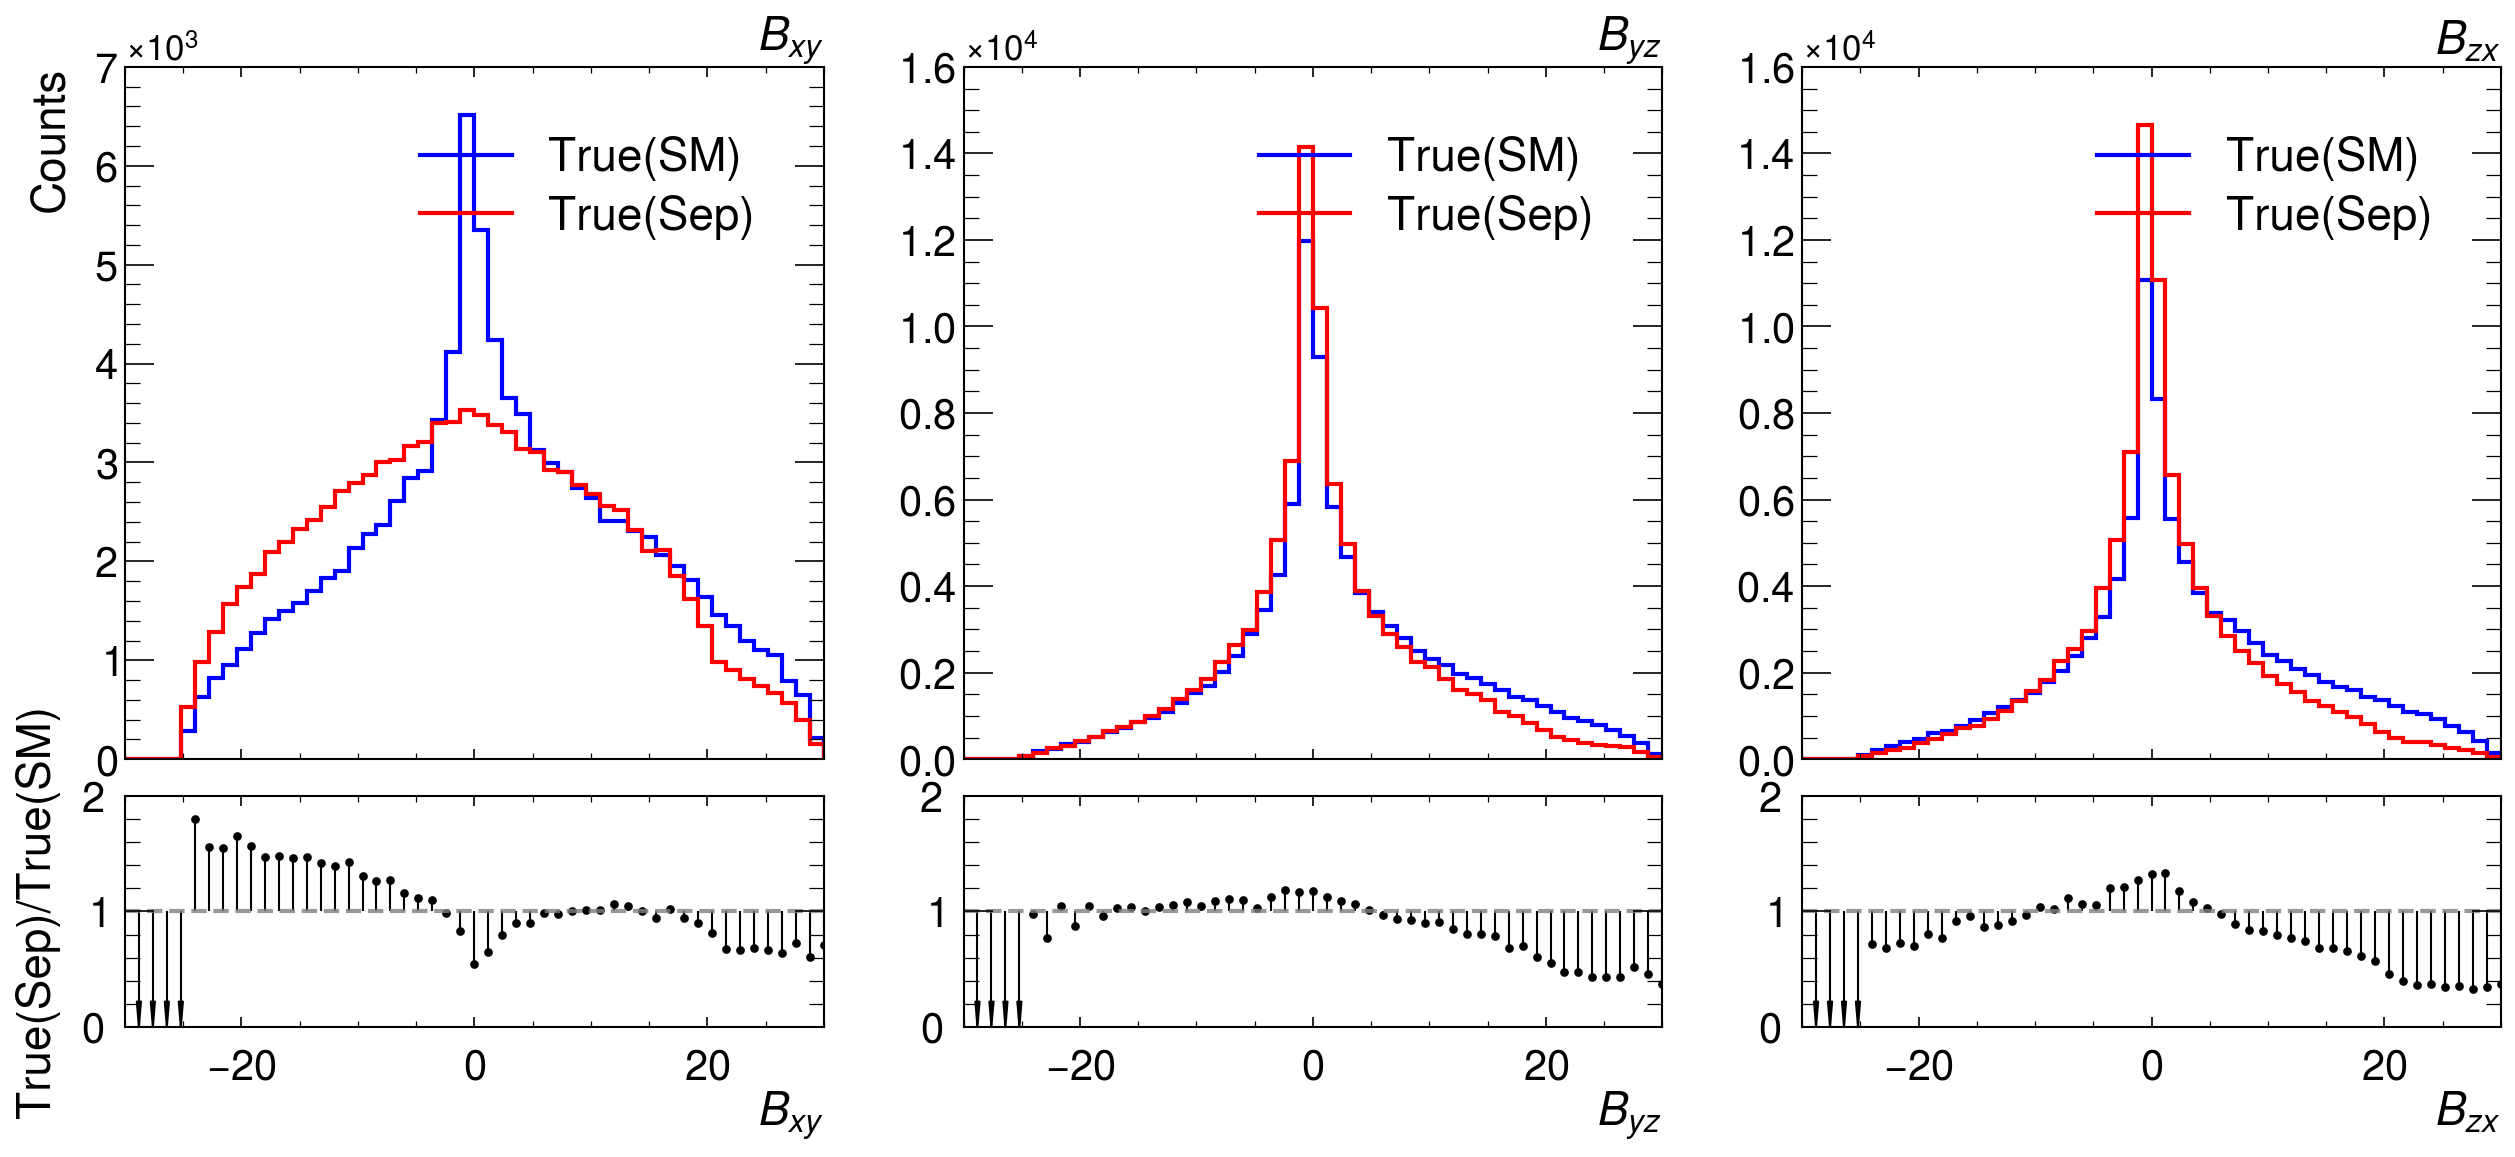


Bxy -> EMD:2.203, kl: 0.789 with SM mean:2.217, Sep mean 0.014
Byz -> EMD:1.477, kl: 0.469 with SM mean:2.499, Sep mean 1.048
Bzx -> EMD:2.035, kl: 0.967 with SM mean:2.748, Sep mean 0.943



In [19]:
# !
"""
Xi comparison:

LL (ground truth) vs SM (ground truth)
"""

print("LL (ground truth) vs SM (ground truth)")

# xi
xi_plot_true = [
    np.random.choice(truth_xi_p[:, 0], 100_000),
    np.random.choice(truth_xi_p[:, 1], 100_000),
    np.random.choice(truth_xi_p[:, 2], 100_000),
    np.random.choice(truth_xi_n[:, 0], 100_000),
    np.random.choice(truth_xi_n[:, 1], 100_000),
    np.random.choice(truth_xi_n[:, 2], 100_000),
]
xi_plot_pred = [
    np.random.choice(truth_xi_p_ll[:, 0], 100_000),
    np.random.choice(truth_xi_p_ll[:, 1], 100_000),
    np.random.choice(truth_xi_p_ll[:, 2], 100_000),
    np.random.choice(truth_xi_n_ll[:, 0], 100_000),
    np.random.choice(truth_xi_n_ll[:, 1], 100_000),
    np.random.choice(truth_xi_n_ll[:, 2], 100_000),
]
xi_plot_ranges = [[-1, 1]] * 6
xi_plot_labels = [
    r"$\xi^{+}_{n}$",
    r"$\xi^{+}_{r}$",
    r"$\xi^{+}_{k}$",
    r"$\xi^{-}_{n}$",
    r"$\xi^{-}_{r}$",
    r"$\xi^{-}_{k}$",
]
plot.hist_1d_grid(
    xi_plot_true,
    xi_plot_pred,
    title=xi_plot_labels,
    legend_lst=["True(Sep)", "True(SM)"],
    ranges=xi_plot_ranges,
    xlabel="",
)
# plot.hist_2d_grid(
#     xi_plot_true,
#     xi_plot_pred,
#     title=xi_plot_labels,
#     ranges=xi_plot_ranges,
#     xlabel="True(SM)",
#     ylabel="True(Sep)",
# )

# bij
bij_plot_true = [
    np.random.choice(truth_bij[:, 0], 100_000),
    np.random.choice(truth_bij[:, 1], 100_000),
    np.random.choice(truth_bij[:, 2], 100_000),
]
bij_plot_pred = [
    np.random.choice(truth_bij_ll[:, 0], 100_000),
    np.random.choice(truth_bij_ll[:, 1], 100_000),
    np.random.choice(truth_bij_ll[:, 2], 100_000),
]
bij_plot_ranges = [[-30, 30]] * 3
bij_plot_labels = [
    r"$B_{xy}$",
    r"$B_{yz}$",
    r"$B_{zx}$",
]

plot.hist_1d3plot(
    bij_plot_true,
    bij_plot_pred,
    ranges=bij_plot_ranges,
    xlabel=bij_plot_labels,
    title=bij_plot_labels,
    row1_ylabel="Counts",
    row1_legend=["True(Sep)", "True(SM)"],
    xpad=1,
)

emd = [
    sp.stats.wasserstein_distance(truth_bij[:, i], truth_bij_ll[:, i]) for i in range(3)
]

kl_lst = []
for i in range(3):
    # Create histograms
    p, bin_edges = np.histogram(truth_bij[..., i], bins=101, density=True)
    q, _ = np.histogram(truth_bij_ll[..., i], bins=bin_edges, density=True)

    # Normalize histograms
    kl = np.sum(sp.special.kl_div(p, q+1e-10))
    kl_lst.append(kl)
    
mean_true = [np.mean(truth_bij[:, i]) for i in range(3)]
mean_ll = [np.mean(truth_bij_ll[:, i]) for i in range(3)]

print(
    rf"""
Bxy -> EMD:{emd[0]:.3f}, kl: {10*kl_lst[0]:.3f} with SM mean:{mean_true[0]:.3f}, Sep mean {mean_ll[0]:.3f}
Byz -> EMD:{emd[1]:.3f}, kl: {10*kl_lst[1]:.3f} with SM mean:{mean_true[1]:.3f}, Sep mean {mean_ll[1]:.3f}
Bzx -> EMD:{emd[2]:.3f}, kl: {10*kl_lst[2]:.3f} with SM mean:{mean_true[2]:.3f}, Sep mean {mean_ll[2]:.3f}
"""
)

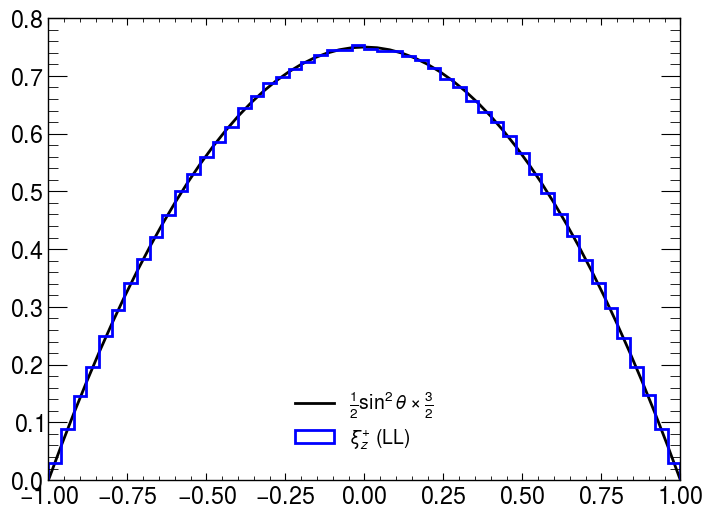

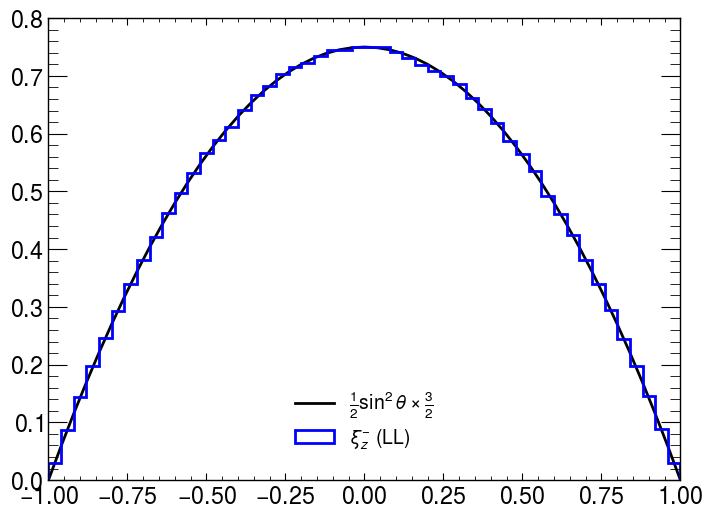

In [20]:
bins_edges = np.linspace(-1, 1, 51)
y_l = 0.5 * (1 - np.square(bins_edges)) * (3/2)
y_neg = 0.25 * np.square(1 + bins_edges) * (3/2)
y_pos = 0.25 * np.square(1 - bins_edges) * (3/2)
plt.plot(bins_edges, y_l, label=r"$\frac{1}{2}\sin^2\theta \times \frac{3}{2}$", color="black", linewidth=2)
# plt.plot(bins_edges, y_neg, label=r"$\frac{1}{4}(1+\cos\theta)^2 \times \frac{3}{2}$", color="red", linewidth=2)
# plt.plot(bins_edges, y_pos, label=r"$\frac{1}{4}(1-\cos\theta)^2 \times \frac{3}{2}$", color="green", linewidth=2)
plt.hist(truth_xi_p_ll[:, 2], bins=bins_edges, density=True, label=r"$\xi^{+}_{z}$ (LL)", histtype="step", linewidth=2, color="blue")
plt.legend()
plt.show()

y_l = 0.5 * (1 - np.square(bins_edges)) * (3/2)
plt.plot(bins_edges, y_l, label=r"$\frac{1}{2}\sin^2\theta \times \frac{3}{2}$", color="black", linewidth=2)
plt.hist(truth_xi_n_ll[:, 2], bins=bins_edges, density=True, label=r"$\xi^{-}_{z}$ (LL)", histtype="step", linewidth=2, color="blue")
plt.legend()
plt.show()

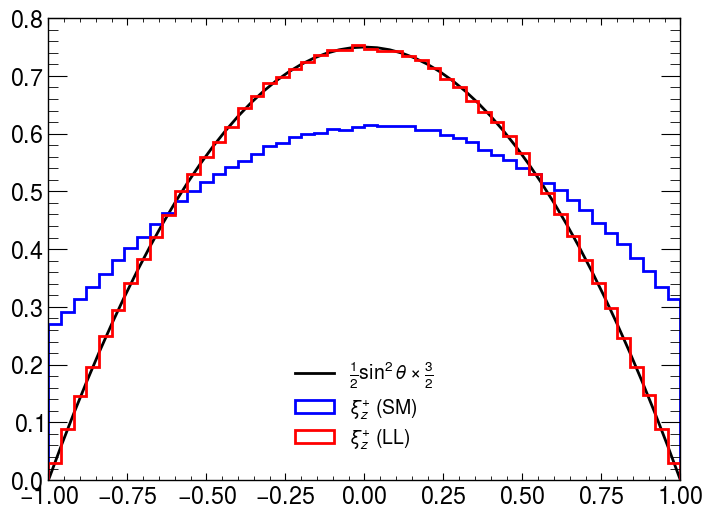

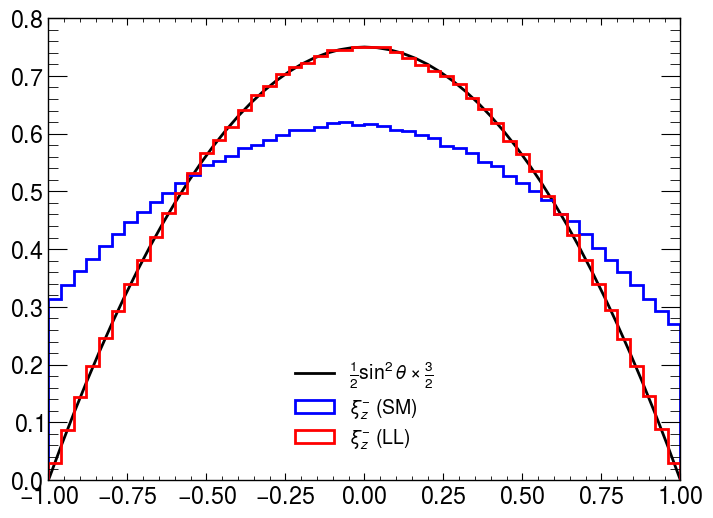

In [21]:
bins_edges = np.linspace(-1, 1, 51)
y_l = 0.5 * (1 - np.square(bins_edges)) * (3/2)
y_neg = 0.25 * np.square(1 + bins_edges) * (3/2)
y_pos = 0.25 * np.square(1 - bins_edges) * (3/2)
plt.plot(bins_edges, y_l, label=r"$\frac{1}{2}\sin^2\theta \times \frac{3}{2}$", color="black", linewidth=2)
# plt.plot(bins_edges, y_neg, label=r"$\frac{1}{4}(1+\cos\theta)^2 \times \frac{3}{2}$", color="red", linewidth=2)
# plt.plot(bins_edges, y_pos, label=r"$\frac{1}{4}(1-\cos\theta)^2 \times \frac{3}{2}$", color="green", linewidth=2)
plt.hist(truth_xi_p[:, 2], bins=bins_edges, density=True, label=r"$\xi^{+}_{z}$ (SM)", histtype="step", linewidth=2, color="blue")
plt.hist(truth_xi_p_ll[:, 2], bins=bins_edges, density=True, label=r"$\xi^{+}_{z}$ (LL)", histtype="step", linewidth=2, color="red")
plt.legend()
plt.show()

y_l = 0.5 * (1 - np.square(bins_edges)) * (3/2)
plt.plot(bins_edges, y_l, label=r"$\frac{1}{2}\sin^2\theta \times \frac{3}{2}$", color="black", linewidth=2)
plt.hist(truth_xi_n[:, 2], bins=bins_edges, density=True, label=r"$\xi^{-}_{z}$ (SM)", histtype="step", linewidth=2, color="blue")
plt.hist(truth_xi_n_ll[:, 2], bins=bins_edges, density=True, label=r"$\xi^{-}_{z}$ (LL)", histtype="step", linewidth=2, color="red")
plt.legend()
plt.show()

In [22]:
t_end = time.time()
print(f"Time elapsed: {t_end - t_start:.2f} s")
print("Done!")

Time elapsed: 95.93 s
Done!
